In [ ]:
import os
import time
import wandb # Keep import, but set USE_WANDB = False
import logging
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, Subset, SubsetRandomSampler
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, average_precision_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau # For learning rate scheduling

# --- Hardcoded Configuration Parameters ---
IMAGE_SIZE = 256
BATCH_SIZE = 32
AUGMENT = True
USE_WANDB = False # Set to False for now
MODEL_FILTERS = [32, 64, 128, 256] # Deeper CNN filters
MODEL_KERNEL_SIZE = 3
MODEL_DROPOUT_RATE = 0.3
MODEL_LEARNING_RATE = 0.0001
AUGMENTATION_ROTATION_RANGE = 20
AUGMENTATION_FLIP_HORIZONTAL = True
AUGMENTATION_FLIP_VERTICAL = True
AUGMENTATION_ZOOM_RANGE = [0.9, 1.1]
AUGMENTATION_SHARPEN_FACTOR = 0.0
N_FOLDS = 5
TEST_SIZE = 0.2
RANDOM_STATE = 42
LOG_LEVEL = "INFO"
DATA_DIRECTORIES = {
    "100x": "/kaggle/input/histopathological-imaging-oral-cancer-analysis/First Set",
    "400x": "/kaggle/input/histopathological-imaging-oral-cancer-analysis/Second Set"
}
NUM_WORKERS = 4
PATIENCE = 10 # Patience for Early Stopping
NUM_EPOCHS = 50 # Increased epochs

In [ ]:
import os
import torch
import logging

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='best_model_fold_1.pth', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
            trace_func (function): trace print function.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        
        # Ensure directory exists
        self.path = path
        self.directory = os.path.dirname(self.path)
        
        # Create directory if it doesn't exist
        if self.directory and not os.path.exists(self.directory):
            os.makedirs(self.directory, exist_ok=True)
        
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        # Ensure directory exists before saving
        os.makedirs(os.path.dirname(self.path), exist_ok=True)
        
        # Handle DataParallel models
        if hasattr(model, 'module'):
            torch.save(model.module.state_dict(), self.path)
        else:
            torch.save(model.state_dict(), self.path)
        
        self.val_loss_min = val_loss

In [ ]:
# --- Configure Logging ---
logging.basicConfig(level=LOG_LEVEL, format='%(asctime)s - %(levelname)s - %(message)s')

def configure_logging_wandb(use_wandb=True, project_name="oral-cancer-classification-pytorch-kfold", run_name=None):
    """
    Configure logging with ability to enable/disable wandb (Wandb functionality is kept, but disabled by USE_WANDB=False)
    """
    global USE_WANDB
    USE_WANDB = use_wandb

    config_log = {
        "logging_enabled": use_wandb,
        "log_dir": "logs"
    }

    if not use_wandb:
        if not os.path.exists(config_log["log_dir"]):
            os.makedirs(config_log["log_dir"])
    else:
        if wandb.run is None:
            wandb.init(
                project=project_name,
                name=run_name or f"oral-cancer-model-pytorch-kfold-{time.strftime('%Y%m%d-%H%M%S')}",
                config={
                    "image_size": IMAGE_SIZE,
                    "batch_size": BATCH_SIZE,
                    "augmentation": AUGMENT,
                    "n_folds": N_FOLDS
                }
            )
        config_log["wandb_run"] = wandb.run
    return config_log

# --- GPU Device Check ---
def get_device():
    """Checks for CUDA availability and returns the appropriate device."""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print("Using CPU.")
    return device

DEVICE = get_device()

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, ConcatDataset, Subset
from sklearn.model_selection import train_test_split
import os
import logging

def load_image_data_pytorch(data_directories, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, 
                             validation_split=TEST_SIZE, seed=RANDOM_STATE, num_workers=NUM_WORKERS):
    """
    Load image data with dataset-specific normalization and GPU-optimized data loading.
    
    Args:
        data_directories (dict): Dictionary of magnification levels and corresponding data directories
        image_size (int): Size to resize images
        batch_size (int): Batch size for DataLoader
        validation_split (float): Proportion of data to use for validation
        seed (int): Random seed for reproducibility
        num_workers (int): Number of worker processes for data loading
    
    Returns:
        tuple: (train_loader, val_loader, class_names)
    """
    # Set random seed for reproducibility
    torch.manual_seed(seed)

    # Base transforms (common for all datasets)
    base_transforms_list = [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ]

    # Optional image sharpening
    if AUGMENT and AUGMENTATION_SHARPEN_FACTOR > 0.0:
        base_transforms_list.append(
            transforms.Lambda(
                lambda img: torch.clamp(
                    torch.sigmoid(
                        transforms.functional.adjust_sharpness(
                            img, 
                            sharpness_factor=AUGMENTATION_SHARPEN_FACTOR
                        )
                    ), 
                    0, 
                    1
                )
            )
        )
    base_transforms = transforms.Compose(base_transforms_list)

    # Augmentation transforms
    augmentation_transforms_list = []
    if AUGMENT:
        augmentation_transforms_list.extend([
            transforms.RandomRotation(degrees=AUGMENTATION_ROTATION_RANGE),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, scale=tuple(AUGMENTATION_ZOOM_RANGE))
        ])
    augmentation_transforms = transforms.Compose(augmentation_transforms_list)
    
    # Combine transforms
    train_transforms = transforms.Compose(augmentation_transforms_list + base_transforms_list)
    val_transforms = base_transforms

    # Collect datasets for normalization calculation
    train_datasets_for_norm = []
    all_data = []
    all_labels = []
    image_folder_datasets = {}

    # First pass: Collect data and prepare for normalization
    for magnification, data_dir in data_directories.items():
        print(f"Loading data from {data_dir} ({magnification} magnification)")
        if not os.path.exists(data_dir):
            raise FileNotFoundError(f"Data directory '{data_dir}' not found.")

        # Dataset for normalization calculation
        train_dataset_mag_no_norm = datasets.ImageFolder(root=data_dir, transform=base_transforms)
        train_datasets_for_norm.append(train_dataset_mag_no_norm)

        # Store datasets for later use
        train_dataset_mag = datasets.ImageFolder(root=data_dir, transform=train_transforms)
        image_folder_datasets[magnification] = train_dataset_mag

        # Collect all data for stratified splitting
        temp_dataset_for_split = datasets.ImageFolder(root=data_dir, transform=base_transforms)
        for img, label in temp_dataset_for_split:
            all_data.append((img, label))
            all_labels.append(label)

    # Calculate normalization statistics
    logging.info("Calculating normalization statistics...")
    mean, std = calculate_normalization_stats(ConcatDataset(train_datasets_for_norm))
    logging.info(f"Calculated mean: {mean}, std: {std}")

    # Create final transforms with normalization
    normalize_transform = transforms.Normalize(mean=mean, std=std)
    train_transforms_final = transforms.Compose(train_transforms.transforms + [normalize_transform])
    val_transforms_final = transforms.Compose(val_transforms.transforms + [normalize_transform])

    # Handle full dataset loading
    if validation_split == 0.0:
        class_names = image_folder_datasets[list(image_folder_datasets.keys())[0]].classes
        full_dataset = ConcatDataset(list(image_folder_datasets.values()))
        full_loader = DataLoader(
            full_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=num_workers, 
            pin_memory=True,  # Optimize for GPU
            prefetch_factor=2  # Improve data loading efficiency
        )
        return full_loader, None, class_names

    # Stratified train-validation split
    train_indices, val_indices, _, _ = train_test_split(
        range(len(all_data)),
        all_labels,
        test_size=validation_split,
        stratify=all_labels,
        random_state=seed
    )

    # Prepare DataLoaders with GPU optimizations
    train_subset = Subset(all_data, train_indices)
    val_subset = Subset(all_data, val_indices)
    
    train_loader = DataLoader(
        train_subset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers, 
        pin_memory=True,  # Enable fast data transfer to GPU
        prefetch_factor=2,  # Preload next batches
        persistent_workers=True  # Keep workers alive between epochs
    )
    
    val_loader = DataLoader(
        val_subset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers, 
        pin_memory=True,  # Enable fast data transfer to GPU
        prefetch_factor=2
    )

    # Get class names
    class_names = image_folder_datasets[list(image_folder_datasets.keys())[0]].classes

    return train_loader, val_loader, class_names


def calculate_normalization_stats(dataset):
    """
    Calculates mean and standard deviation for normalization from the dataset.
    
    Args:
        dataset (torch.utils.data.Dataset): Dataset to calculate statistics from
    
    Returns:
        tuple: (mean, std) for normalization
    """
    # Use DataLoader with GPU-optimized settings
    dataloader = DataLoader(
        dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=NUM_WORKERS, 
        pin_memory=True
    )
    
    # Use device-agnostic tensor initialization
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mean_total = torch.zeros(3, device=device)
    std_total = torch.zeros(3, device=device)
    num_batches = 0

    # Improved normalization stats calculation
    for images, _ in dataloader:
        # Move images to the same device
        images = images.to(device)
        
        # Reshape and calculate statistics
        images = images.reshape(-1, 3, IMAGE_SIZE * IMAGE_SIZE)
        mean_batch = images.mean(dim=2).sum(dim=0)
        std_batch = images.std(dim=2).sum(dim=0)

        mean_total += mean_batch
        std_total += std_batch
        num_batches += len(images)

    # Move final calculations back to CPU for compatibility
    mean = (mean_total / num_batches).cpu()
    std = (std_total / num_batches).cpu()
    
    return mean, std

In [ ]:
class DeeperCNN(nn.Module):
    def __init__(self, num_classes=1, filters_list=MODEL_FILTERS, kernel_size=MODEL_KERNEL_SIZE, dropout_rate=MODEL_DROPOUT_RATE):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, filters_list[0], kernel_size=kernel_size, padding='same')
        self.bn1 = nn.BatchNorm2d(filters_list[0])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.conv2 = nn.Conv2d(filters_list[0], filters_list[1], kernel_size=kernel_size, padding='same')
        self.bn2 = nn.BatchNorm2d(filters_list[1])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.conv3 = nn.Conv2d(filters_list[1], filters_list[2], kernel_size=kernel_size, padding='same')
        self.bn3 = nn.BatchNorm2d(filters_list[2])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.conv4 = nn.Conv2d(filters_list[2], filters_list[3], kernel_size=kernel_size, padding='same') # Added Conv4
        self.bn4 = nn.BatchNorm2d(filters_list[3])
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(dropout_rate)


        self.flatten = nn.Flatten()

        feature_map_size = IMAGE_SIZE // (2**4) # Now 4 pooling layers
        linear_input_size = filters_list[3] * feature_map_size * feature_map_size # Use filters_list[3]

        self.fc1 = nn.Linear(linear_input_size, 128) # Increased FC1 size
        self.dropout_fc1 = nn.Dropout(dropout_rate) # Dropout after FC1
        self.fc2 = nn.Linear(128, 64) # Added FC2 layer
        self.dropout_fc2 = nn.Dropout(dropout_rate) # Dropout after FC2
        self.fc_out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.dropout1(self.pool1(F.relu(self.bn1(self.conv1(x)))))
        x = self.dropout2(self.pool2(F.relu(self.bn2(self.conv2(x)))))
        x = self.dropout3(self.pool3(F.relu(self.bn3(self.conv3(x)))))
        x = self.dropout4(self.pool4(F.relu(self.bn4(self.conv4(x))))) # Added Conv4 layer

        x = self.flatten(x)

        x = self.dropout_fc1(F.relu(self.fc1(x))) # FC1 with dropout
        x = self.dropout_fc2(F.relu(self.fc2(x))) # FC2 with dropout
        x = torch.sigmoid(self.fc_out(x))
        return x

In [ ]:
import torch
import numpy as np
from sklearn.metrics import (
    roc_auc_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix
)

def calculate_metrics(outputs, labels):
    """
    Calculates comprehensive performance metrics for binary classification.
    
    Args:
        outputs (torch.Tensor): Model predictions (probabilities)
        labels (torch.Tensor): Ground truth labels
    
    Returns:
        tuple: Accuracy, AUC, Precision, Recall, F1-score, Specificity, Sensitivity
    """
    # Ensure inputs are on CPU and converted to numpy
    outputs_np = outputs.detach().cpu().numpy()
    labels_np = labels.detach().cpu().numpy()

    # Predicted classes using threshold
    predicted_classes = (outputs > 0.5).int().cpu().numpy()

    # Accuracy
    accuracy = np.mean(predicted_classes == labels_np)

    # AUC (Area Under ROC Curve)
    try:
        # Handle single-class scenarios
        if len(np.unique(labels_np)) == 1:
            auc = float('nan')
        else:
            auc = roc_auc_score(labels_np, outputs_np)
    except ValueError:
        # Fallback for problematic AUC calculation
        auc = float('nan')
        logging.warning("Unable to calculate AUC. Ensure binary classification scenario.")

    # Precision, Recall, F1-Score with robust handling
    precision = precision_score(
        labels_np, 
        predicted_classes, 
        zero_division=0,  # Return 0 if no positive predictions
        average='binary'
    )
    
    recall = recall_score(
        labels_np, 
        predicted_classes, 
        zero_division=0,
        average='binary'
    )
    
    f1 = f1_score(
        labels_np, 
        predicted_classes, 
        zero_division=0,
        average='binary'
    )

    # Confusion Matrix for Specificity Calculation
    try:
        cm = confusion_matrix(labels_np, predicted_classes)
        tn, fp, fn, tp = cm.ravel()
        
        # Robust Specificity Calculation
        specificity = tn / (tn + fp + 1e-8)
        sensitivity = tp / (tp + fn + 1e-8)
    except Exception as e:
        logging.warning(f"Error in confusion matrix calculation: {e}")
        specificity = sensitivity = float('nan')

    return (
        torch.tensor(accuracy), 
        auc, 
        precision, 
        recall, 
        f1, 
        specificity, 
        sensitivity
    )

In [ ]:
def plot_roc_curve(val_labels, val_outputs, epoch, fold, val_auc, results_dir="results"): # Added val_auc to function args
    """Plots ROC curve and saves to results directory."""
    fpr, tpr, thresholds = roc_curve(val_labels.cpu().numpy(), val_outputs.cpu().numpy())
    # roc_auc = roc_auc_score(val_labels.cpu().numpy(), val_outputs.cpu().numpy()) # AUC already calculated

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Validation AUC (Fold {fold+1}) = {val_auc:.3f}') # Use provided val_auc
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Validation ROC Curve - Epoch {epoch+1}, Fold {fold+1}')
    plt.legend(loc='lower right')

    results_dir = ensure_results_directory(results_dir) # Ensure results directory exists (you'll need to define this function, see below)
    filepath = os.path.join(results_dir, f'roc_curve_fold_{fold+1}_epoch_{epoch+1}.png') # Filename with epoch number
    plt.savefig(filepath) # Save ROC curve plot
    plt.close()

    if USE_WANDB:
        wandb.log({f"val_fold_{fold+1}/roc_curve": wandb.Image(filepath), 'epoch': epoch+1})

def plot_confusion_matrix(val_labels, val_outputs, class_names, epoch, fold, val_accuracy, val_precision, val_recall, val_f1, val_specificity, val_sensitivity, results_dir="results"): # Added more metrics to function args
    """Plots confusion matrix and saves to results directory."""
    predicted_classes = (val_outputs > 0.5).int()
    cm = confusion_matrix(val_labels.cpu().numpy(), predicted_classes.cpu().numpy())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, annot_kws={"fontsize":10}) # Increased fontsize for annotations
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    title_str = f'Validation Confusion Matrix - Epoch {epoch+1}, Fold {fold+1}\n' # Start title string
    title_str += f'Acc: {val_accuracy:.3f}, AUC: {roc_auc_score(val_labels.cpu().numpy(), val_outputs.cpu().numpy()):.3f}\n' # Add Accuracy and AUC to title
    title_str += f'Prec: {val_precision:.3f}, Rec: {val_recall:.3f}, F1: {val_f1:.3f}\n' # Add Precision, Recall, F1
    title_str += f'Spec: {val_specificity:.3f}, Sens: {val_sensitivity:.3f}' # Add Specificity, Sensitivity
    plt.title(title_str, fontsize=10) # Set title with all metrics and smaller fontsize
    plt.tight_layout()

    results_dir = ensure_results_directory(results_dir) # Ensure results directory exists
    filepath = os.path.join(results_dir, f'confusion_matrix_fold_{fold+1}_epoch_{epoch+1}.png')
    plt.savefig(filepath) # Save confusion matrix plot
    plt.close()

    if USE_WANDB:
        wandb.log({f"val_fold_{fold+1}/confusion_matrix": wandb.Image(filepath), 'epoch': epoch+1})

def ensure_results_directory(results_dir="results"):
    """Ensures that the results directory exists, creates it if not."""
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    return results_dir

In [ ]:
import torch
import numpy as np
import logging

def train_epoch(model, train_loader, criterion, optimizer, epoch, fold):
    """
    Performs training for one epoch with GPU optimization and detailed logging.
    
    Args:
        model (torch.nn.Module): Neural network model
        train_loader (torch.utils.data.DataLoader): Training data loader
        criterion (torch.nn.Module): Loss function
        optimizer (torch.optim.Optimizer): Optimization algorithm
        epoch (int): Current epoch number
        fold (int): Current cross-validation fold
    
    Returns:
        tuple: Average train loss, accuracy, and AUC
    """
    # Ensure model is in training mode
    model.train()
    
    # Initialize metrics tracking
    train_metrics = {
        'loss': 0.0,
        'accuracy': 0.0,
        'auc': 0.0
    }
    num_train_batches = 0

    # Use torch.autograd.set_detect_anomaly for debugging
    with torch.autograd.set_detect_anomaly(True):
        for batch_idx, batch in enumerate(train_loader):
            # Move data to device and ensure correct dtype
            images = batch[0].to(DEVICE, dtype=torch.float32)
            labels = batch[1].to(DEVICE, dtype=torch.float32)

            # Zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)  # More memory efficient

            # Forward pass
            outputs = model(images).flatten()

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Compute batch metrics
            try:
                batch_metrics = calculate_metrics(outputs, labels)
                batch_accuracy, batch_auc, *_ = batch_metrics

                # Accumulate metrics
                train_metrics['loss'] += loss.item()
                train_metrics['accuracy'] += batch_accuracy.item()
                
                # Handle potential NaN in AUC
                if not np.isnan(batch_auc):
                    train_metrics['auc'] += batch_auc
                else:
                    logging.warning(
                        f"Fold [{fold+1}/{N_FOLDS}], "
                        f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
                        f"Batch [{batch_idx}/{len(train_loader)}]: "
                        "AUC is NaN, skipping accumulation."
                    )

                num_train_batches += 1

                # Periodic logging
                if batch_idx % 10 == 0:
                    print(
                        f'  Fold [{fold+1}/{N_FOLDS}], '
                        f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                        f'Batch [{batch_idx}/{len(train_loader)}], '
                        f'Train Loss: {loss.item():.4f}'
                    )

            except Exception as e:
                logging.error(f"Error processing batch {batch_idx}: {e}")
                continue

    # Compute average metrics
    def safe_avg(total, count):
        return total / count if count > 0 else 0

    return (
        safe_avg(train_metrics['loss'], num_train_batches),
        safe_avg(train_metrics['accuracy'], num_train_batches),
        safe_avg(train_metrics['auc'], num_train_batches)
    )


def validate_epoch(model, val_loader, criterion, epoch, fold, class_names, results_dir):
    """
    Performs validation for one epoch with comprehensive metric tracking.
    
    Args:
        model (torch.nn.Module): Neural network model
        val_loader (torch.utils.data.DataLoader): Validation data loader
        criterion (torch.nn.Module): Loss function
        epoch (int): Current epoch number
        fold (int): Current cross-validation fold
        class_names (list): List of class names
        results_dir (str): Directory to save results
    
    Returns:
        tuple: Average validation metrics
    """
    # Ensure model is in evaluation mode
    model.eval()
    
    # Initialize metrics tracking
    val_metrics = {
        'loss': 0.0,
        'accuracy': 0.0,
        'auc': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'f1': 0.0,
        'specificity': 0.0,
        'sensitivity': 0.0
    }
    num_val_batches = 0
    
    # Lists to store all predictions and labels for final analysis
    all_val_labels = []
    all_val_outputs = []

    # Disable gradient computation for efficiency
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            # Move data to device and ensure correct dtype
            images = batch[0].to(DEVICE, dtype=torch.float32)
            labels = batch[1].to(DEVICE, dtype=torch.float32)

            # Forward pass
            outputs = model(images).flatten()

            # Compute loss
            loss = criterion(outputs, labels)

            # Compute batch metrics
            batch_metrics = calculate_metrics(outputs, labels)
            (
                batch_accuracy, batch_auc, batch_precision, 
                batch_recall, batch_f1, batch_specificity, 
                batch_sensitivity
            ) = batch_metrics

            # Accumulate metrics
            val_metrics['loss'] += loss.item()
            val_metrics['accuracy'] += batch_accuracy.item()
            val_metrics['auc'] += batch_auc
            val_metrics['precision'] += batch_precision
            val_metrics['recall'] += batch_recall
            val_metrics['f1'] += batch_f1
            val_metrics['specificity'] += batch_specificity
            val_metrics['sensitivity'] += batch_sensitivity

            num_val_batches += 1
            
            # Store predictions and labels for detailed analysis
            all_val_labels.append(labels)
            all_val_outputs.append(outputs)

    # Compute average metrics
    def safe_avg(total, count):
        return total / count if count > 0 else 0

    # Compute averages
    avg_metrics = {
        key: safe_avg(val_metrics[key], num_val_batches) 
        for key in val_metrics
    }

    # Print validation summary
    print(f'  Fold [{fold+1}/{N_FOLDS}], Epoch [{epoch+1}/{NUM_EPOCHS}], '
          f'Avg. Val Loss: {avg_metrics["loss"]:.4f}, '
          f'Avg. Val Accuracy: {avg_metrics["accuracy"]:.4f}, '
          f'Avg. Val AUC: {avg_metrics["auc"]:.4f}')
    print(f'  Validation Metrics - '
          f'Precision: {avg_metrics["precision"]:.4f}, '
          f'Recall: {avg_metrics["recall"]:.4f}, '
          f'F1: {avg_metrics["f1"]:.4f}, '
          f'Specificity: {avg_metrics["specificity"]:.4f}, '
          f'Sensitivity: {avg_metrics["sensitivity"]:.4f}')

    # Concatenate tensors for plotting
    try:
        all_val_labels = torch.cat(all_val_labels)
        all_val_outputs = torch.cat(all_val_outputs)
        
        # Plot ROC curve and confusion matrix
        plot_roc_curve(
            all_val_labels, all_val_outputs, 
            epoch, fold, avg_metrics['auc'], results_dir
        )
        plot_confusion_matrix(
            all_val_labels, all_val_outputs, class_names, 
            epoch, fold, 
            avg_metrics['accuracy'], avg_metrics['precision'], 
            avg_metrics['recall'], avg_metrics['f1'], 
            avg_metrics['specificity'], avg_metrics['sensitivity'], 
            results_dir
        )
    except Exception as e:
        logging.error(f"Error in plotting: {e}")

    # Return all computed metrics
    return tuple(avg_metrics.values())

In [ ]:
import os
import time
import wandb # Keep import, but set USE_WANDB = False
import logging
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, Subset, SubsetRandomSampler
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, average_precision_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau # For learning rate scheduling

# --- Hardcoded Configuration Parameters ---
IMAGE_SIZE = 256
BATCH_SIZE = 32
AUGMENT = True
USE_WANDB = False # Set to False for now
MODEL_FILTERS = [32, 64, 128, 256] # Deeper CNN filters
MODEL_KERNEL_SIZE = 3
MODEL_DROPOUT_RATE = 0.3
MODEL_LEARNING_RATE = 0.0001
AUGMENTATION_ROTATION_RANGE = 20
AUGMENTATION_FLIP_HORIZONTAL = True
AUGMENTATION_FLIP_VERTICAL = True
AUGMENTATION_ZOOM_RANGE = [0.9, 1.1]
AUGMENTATION_SHARPEN_FACTOR = 0.0
N_FOLDS = 5
TEST_SIZE = 0.2
RANDOM_STATE = 42
LOG_LEVEL = "INFO"
DATA_DIRECTORIES = {
    "100x": "/kaggle/input/histopathological-imaging-oral-cancer-analysis/First Set",
    "400x": "/kaggle/input/histopathological-imaging-oral-cancer-analysis/Second Set"
}
NUM_WORKERS = 4
PATIENCE = 10 # Patience for Early Stopping
NUM_EPOCHS = 50 # Increased epochs

import os
import torch
import logging

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='best_model_fold_1.pth', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path for the checkpoint to be saved to.
            trace_func (function): trace print function.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

        self.path = path
        self.directory = os.path.dirname(self.path)
        if self.directory and not os.path.exists(self.directory):
            os.makedirs(self.directory, exist_ok=True)
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        os.makedirs(os.path.dirname(self.path), exist_ok=True)
        if hasattr(model, 'module'):
            torch.save(model.module.state_dict(), self.path)
        else:
            torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# --- Configure Logging ---
logging.basicConfig(level=LOG_LEVEL, format='%(asctime)s - %(levelname)s - %(message)s')

def configure_logging_wandb(use_wandb=True, project_name="oral-cancer-classification-pytorch-kfold", run_name=None):
    """
    Configure logging with ability to enable/disable wandb (Wandb functionality is kept, but disabled by USE_WANDB=False)
    """
    global USE_WANDB
    USE_WANDB = use_wandb

    config_log = {
        "logging_enabled": use_wandb,
        "log_dir": "logs"
    }

    if not use_wandb:
        if not os.path.exists(config_log["log_dir"]):
            os.makedirs(config_log["log_dir"])
    else:
        if wandb.run is None:
            wandb.init(
                project=project_name,
                name=run_name or f"oral-cancer-model-pytorch-kfold-{time.strftime('%Y%m%d-%H%M%S')}",
                config={
                    "image_size": IMAGE_SIZE,
                    "batch_size": BATCH_SIZE,
                    "augmentation": AUGMENT,
                    "n_folds": N_FOLDS
                }
            )
        config_log["wandb_run"] = wandb.run
    return config_log

# --- GPU Device Check ---
def get_device():
    """Checks for CUDA availability and returns the appropriate device."""
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print("Using CPU.")
    return device

DEVICE = get_device()


import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, ConcatDataset, Subset
from sklearn.model_selection import train_test_split
import os
import logging

def load_image_data_pytorch(data_directories, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                             validation_split=TEST_SIZE, seed=RANDOM_STATE, num_workers=NUM_WORKERS):
    """
    Load image data with dataset-specific normalization and GPU-optimized data loading.

    Args:
        data_directories (dict): Dictionary of magnification levels and corresponding data directories
        image_size (int): Size to resize images
        batch_size (int): Batch size for DataLoader
        validation_split (float): Proportion of data to use for validation
        seed (int): Random seed for reproducibility
        num_workers (int): Number of worker processes for data loading

    Returns:
        tuple: (train_loader, val_loader, class_names)
    """
    # Set random seed for reproducibility
    torch.manual_seed(seed)

    # Base transforms (common for all datasets)
    base_transforms_list = [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ]

    # Optional image sharpening (Standard Sharpening - Example)
    if AUGMENT and AUGMENTATION_SHARPEN_FACTOR > 0.0:
        base_transforms_list.append(
            transforms.Lambda(
                lambda img: transforms.functional.adjust_sharpness(
                    img,
                    sharpness_factor=AUGMENTATION_SHARPEN_FACTOR
                )
            )
        )
    base_transforms = transforms.Compose(base_transforms_list)


    # Augmentation transforms
    augmentation_transforms_list = []
    if AUGMENT:
        augmentation_transforms_list.extend([
            transforms.RandomRotation(degrees=AUGMENTATION_ROTATION_RANGE),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, scale=tuple(AUGMENTATION_ZOOM_RANGE))
        ])
    augmentation_transforms = transforms.Compose(augmentation_transforms_list)

    # Calculate normalization statistics AFTER base_transforms
    train_datasets_for_norm = []
    for magnification, data_dir in data_directories.items():
        train_dataset_mag_no_norm = datasets.ImageFolder(root=data_dir, transform=base_transforms) # Use base_transforms for norm calculation
        train_datasets_for_norm.append(train_dataset_mag_no_norm)

    logging.info("Calculating normalization statistics...")
    mean, std = calculate_normalization_stats(ConcatDataset(train_datasets_for_norm))
    logging.info(f"Calculated mean: {mean}, std: {std}")
    normalize_transform = transforms.Normalize(mean=mean, std=std)


    # Final transforms - normalization is LAST
    train_transforms_final_list = augmentation_transforms_list + base_transforms_list + [normalize_transform] # Normalize last for training
    val_transforms_final_list = base_transforms_list + [normalize_transform] # Normalize last for validation

    train_transforms_final = transforms.Compose(train_transforms_final_list)
    val_transforms_final = transforms.Compose(val_transforms_final_list)


    # Collect datasets and labels for stratified split
    all_data = []
    all_labels = []
    image_folder_datasets = {}
    for magnification, data_dir in data_directories.items():
        print(f"Loading data from {data_dir} ({magnification} magnification)")
        if not os.path.exists(data_dir):
            raise FileNotFoundError(f"Data directory '{data_dir}' not found.")

        train_dataset_mag = datasets.ImageFolder(root=data_dir, transform=train_transforms_final) # Use final transforms
        image_folder_datasets[magnification] = train_dataset_mag

        temp_dataset_for_split = datasets.ImageFolder(root=data_dir, transform=val_transforms_final) # Use final transforms (val is fine for splitting)
        for img, label in temp_dataset_for_split:
            all_data.append((img, label))
            all_labels.append(label)


    # Handle full dataset loading
    if validation_split == 0.0:
        class_names = image_folder_datasets[list(image_folder_datasets.keys())[0]].classes
        full_dataset = ConcatDataset(list(image_folder_datasets.values()))
        full_loader = DataLoader(
            full_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True,  # Optimize for GPU
            prefetch_factor=2  # Improve data loading efficiency
        )
        return full_loader, None, class_names

    # Stratified train-validation split
    train_indices, val_indices, _, _ = train_test_split(
        range(len(all_data)),
        all_labels,
        test_size=validation_split,
        stratify=all_labels,
        random_state=seed
    )

    # Prepare DataLoaders with GPU optimizations
    train_subset = Subset(all_data, train_indices)
    val_subset = Subset(all_data, val_indices)

    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,  # Enable fast data transfer to GPU
        prefetch_factor=2,  # Preload next batches
        persistent_workers=True  # Keep workers alive between epochs
    )

    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,  # Enable fast data transfer to GPU
        prefetch_factor=2
    )

    # Get class names
    class_names = image_folder_datasets[list(image_folder_datasets.keys())[0]].classes

    return train_loader, val_loader, class_names


def calculate_normalization_stats(dataset):
    """
    Calculates mean and standard deviation for normalization from the dataset.

    Args:
        dataset (torch.utils.data.Dataset): Dataset to calculate statistics from

    Returns:
        tuple: (mean, std) for normalization
    """
    # Use DataLoader with GPU-optimized settings
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    # Use device-agnostic tensor initialization
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mean_total = torch.zeros(3, device=device)
    std_total = torch.zeros(3, device=device)
    num_batches = 0

    # Improved normalization stats calculation
    for images, _ in dataloader:
        # Move images to the same device
        images = images.to(device)

        # Reshape and calculate statistics
        images = images.reshape(-1, 3, IMAGE_SIZE * IMAGE_SIZE)
        mean_batch = images.mean(dim=2).sum(dim=0)
        std_batch = images.std(dim=2).sum(dim=0)

        mean_total += mean_batch
        std_total += std_batch
        num_batches += len(images)

    # Move final calculations back to CPU for compatibility
    mean = (mean_total / num_batches).cpu()
    std = (std_total / num_batches).cpu()

    return mean, std

class DeeperCNN(nn.Module):
    def __init__(self, num_classes=1, filters_list=MODEL_FILTERS, kernel_size=MODEL_KERNEL_SIZE, dropout_rate=MODEL_DROPOUT_RATE):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, filters_list[0], kernel_size=kernel_size, padding='same')
        self.bn1 = nn.BatchNorm2d(filters_list[0])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.conv2 = nn.Conv2d(filters_list[0], filters_list[1], kernel_size=kernel_size, padding='same')
        self.bn2 = nn.BatchNorm2d(filters_list[1])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.conv3 = nn.Conv2d(filters_list[1], filters_list[2], kernel_size=kernel_size, padding='same')
        self.bn3 = nn.BatchNorm2d(filters_list[2])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.conv4 = nn.Conv2d(filters_list[2], filters_list[3], kernel_size=kernel_size, padding='same') # Added Conv4
        self.bn4 = nn.BatchNorm2d(filters_list[3])
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(dropout_rate)


        self.flatten = nn.Flatten()

        feature_map_size = IMAGE_SIZE // (2**4) # Now 4 pooling layers
        linear_input_size = filters_list[3] * feature_map_size * feature_map_size # Use filters_list[3]

        self.fc1 = nn.Linear(linear_input_size, 128) # Increased FC1 size
        self.dropout_fc1 = nn.Dropout(dropout_rate) # Dropout after FC1
        self.fc2 = nn.Linear(128, 64) # Added FC2 layer
        self.dropout_fc2 = nn.Dropout(dropout_rate) # Dropout after FC2
        self.fc_out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.dropout1(self.pool1(F.relu(self.bn1(self.conv1(x)))))
        x = self.dropout2(self.pool2(F.relu(self.bn2(self.conv2(x)))))
        x = self.dropout3(self.pool3(F.relu(self.bn3(self.conv3(x)))))
        x = self.dropout4(self.pool4(F.relu(self.bn4(self.conv4(x))))) # Added Conv4 layer

        x = self.flatten(x)

        x = self.dropout_fc1(F.relu(self.fc1(x))) # FC1 with dropout
        x = self.dropout_fc2(F.relu(self.fc2(x))) # FC2 with dropout
        x = torch.sigmoid(self.fc_out(x))
        return x

import torch
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

def calculate_metrics(outputs, labels):
    """
    Calculates comprehensive performance metrics for binary classification.

    Args:
        outputs (torch.Tensor): Model predictions (probabilities)
        labels (torch.Tensor): Ground truth labels

    Returns:
        tuple: Accuracy, AUC, Precision, Recall, F1-score, Specificity, Sensitivity
    """
    # Ensure inputs are on CPU and converted to numpy
    outputs_np = outputs.detach().cpu().numpy()
    labels_np = labels.detach().cpu().numpy()

    # Predicted classes using threshold
    predicted_classes = (outputs > 0.5).int().cpu().numpy()

    # Accuracy
    accuracy = np.mean(predicted_classes == labels_np)

    # AUC (Area Under ROC Curve)
    try:
        # Handle single-class scenarios
        if len(np.unique(labels_np)) == 1:
            auc = float('nan')
        else:
            auc = roc_auc_score(labels_np, outputs_np)
    except ValueError:
        # Fallback for problematic AUC calculation
        auc = float('nan')
        logging.warning("Unable to calculate AUC. Ensure binary classification scenario.")

    # Precision, Recall, F1-Score with robust handling
    precision = precision_score(
        labels_np,
        predicted_classes,
        zero_division=0,  # Return 0 if no positive predictions
        average='binary'
    )

    recall = recall_score(
        labels_np,
        predicted_classes,
        zero_division=0,
        average='binary'
    )

    f1 = f1_score(
        labels_np,
        predicted_classes,
        zero_division=0,
        average='binary'
    )

    # Confusion Matrix for Specificity Calculation
    try:
        cm = confusion_matrix(labels_np, predicted_classes)
        tn, fp, fn, tp = cm.ravel()

        # Robust Specificity Calculation
        specificity = tn / (tn + fp + 1e-8)
        sensitivity = tp / (tp + fn + 1e-8)
    except Exception as e:
        logging.warning(f"Error in confusion matrix calculation: {e}")
        specificity = sensitivity = float('nan')

    return (
        torch.tensor(accuracy),
        auc,
        precision,
        recall,
        f1,
        specificity,
        sensitivity
    )

def plot_roc_curve(val_labels, val_outputs, epoch, fold, val_auc, results_dir="results"): # Added val_auc to function args
    """Plots ROC curve and saves to results directory."""
    fpr, tpr, thresholds = roc_curve(val_labels.cpu().numpy(), val_outputs.cpu().numpy())
    # roc_auc = roc_auc_score(val_labels.cpu().numpy(), val_outputs.cpu().numpy()) # AUC already calculated

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Validation AUC (Fold {fold+1}) = {val_auc:.3f}') # Use provided val_auc
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Validation ROC Curve - Epoch {epoch+1}, Fold {fold+1}')
    plt.legend(loc='lower right')

    results_dir = ensure_results_directory(results_dir) # Ensure results directory exists (you'll need to define this function, see below)
    filepath = os.path.join(results_dir, f'roc_curve_fold_{fold+1}_epoch_{epoch+1}.png') # Filename with epoch number
    plt.savefig(filepath) # Save ROC curve plot
    plt.close()

    if USE_WANDB:
        wandb.log({f"val_fold_{fold+1}/roc_curve": wandb.Image(filepath), 'epoch': epoch+1})

def plot_confusion_matrix(val_labels, val_outputs, class_names, epoch, fold, val_accuracy, val_precision, val_recall, val_f1, val_specificity, val_sensitivity, results_dir="results"): # Added more metrics to function args
    """Plots confusion matrix and saves to results directory."""
    predicted_classes = (val_outputs > 0.5).int()
    cm = confusion_matrix(val_labels.cpu().numpy(), predicted_classes.cpu().numpy())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, annot_kws={"fontsize":10}) # Increased fontsize for annotations
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    title_str = f'Validation Confusion Matrix - Epoch {epoch+1}, Fold {fold+1}\n' # Start title string
    title_str += f'Acc: {val_accuracy:.3f}, AUC: {roc_auc_score(val_labels.cpu().numpy(), val_outputs.cpu().numpy()):.3f}\n' # Add Accuracy and AUC to title
    title_str += f'Prec: {val_precision:.3f}, Rec: {val_recall:.3f}, F1: {val_f1:.3f}\n' # Add Precision, Recall, F1
    title_str += f'Spec: {val_specificity:.3f}, Sens: {val_sensitivity:.3f}' # Add Specificity, Sensitivity
    plt.title(title_str, fontsize=10) # Set title with all metrics and smaller fontsize
    plt.tight_layout()

    results_dir = ensure_results_directory(results_dir) # Ensure results directory exists
    filepath = os.path.join(results_dir, f'confusion_matrix_fold_{fold+1}_epoch_{epoch+1}.png')
    plt.savefig(filepath) # Save confusion matrix plot
    plt.close()

    if USE_WANDB:
        wandb.log({f"val_fold_{fold+1}/confusion_matrix": wandb.Image(filepath), 'epoch': epoch+1})

def ensure_results_directory(results_dir="results"):
    """Ensures that the results directory exists, creates it if not."""
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    return results_dir

import torch
import numpy as np
import logging

def train_epoch(model, train_loader, criterion, optimizer, epoch, fold):
    """
    Performs training for one epoch with GPU optimization and detailed logging.

    Args:
        model (torch.nn.Module): Neural network model
        train_loader (torch.utils.data.DataLoader): Training data loader
        criterion (torch.nn.Module): Loss function
        optimizer (torch.optim.Optimizer): Optimization algorithm
        epoch (int): Current epoch number
        fold (int): Current cross-validation fold

    Returns:
        tuple: Average train loss, accuracy, and AUC
    """
    # Ensure model is in training mode
    model.train()

    # Initialize metrics tracking
    train_metrics = {
        'loss': 0.0,
        'accuracy': 0.0,
        'auc': 0.0
    }
    num_train_batches = 0

    # Use torch.autograd.set_detect_anomaly for debugging
    with torch.autograd.set_detect_anomaly(True):
        for batch_idx, batch in enumerate(train_loader):
            # Move data to device and ensure correct dtype
            images = batch[0].to(DEVICE, dtype=torch.float32)
            labels = batch[1].to(DEVICE, dtype=torch.float32)

            # Zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)  # More memory efficient

            # Forward pass
            outputs = model(images).flatten()

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Compute batch metrics
            try:
                batch_metrics = calculate_metrics(outputs, labels)
                batch_accuracy, batch_auc, *_ = batch_metrics

                # Accumulate metrics
                train_metrics['loss'] += loss.item()
                train_metrics['accuracy'] += batch_accuracy.item()

                # Handle potential NaN in AUC
                if not np.isnan(batch_auc):
                    train_metrics['auc'] += batch_auc
                else:
                    logging.warning(
                        f"Fold [{fold+1}/{N_FOLDS}], "
                        f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
                        f"Batch [{batch_idx}/{len(train_loader)}]: "
                        "AUC is NaN, skipping accumulation."
                    )

                num_train_batches += 1

                # Periodic logging
                if batch_idx % 10 == 0:
                    print(
                        f'  Fold [{fold+1}/{N_FOLDS}], '
                        f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                        f'Batch [{batch_idx}/{len(train_loader)}], '
                        f'Train Loss: {loss.item():.4f}'
                    )

            except Exception as e:
                logging.error(f"Error processing batch {batch_idx}: {e}")
                continue

    # Compute average metrics
    def safe_avg(total, count):
        return total / count if count > 0 else 0

    return (
        safe_avg(train_metrics['loss'], num_train_batches),
        safe_avg(train_metrics['accuracy'], num_train_batches),
        safe_avg(train_metrics['auc'], num_train_batches)
    )


def validate_epoch(model, val_loader, criterion, epoch, fold, class_names, results_dir):
    """
    Performs validation for one epoch with comprehensive metric tracking.

    Args:
        model (torch.nn.Module): Neural network model
        val_loader (torch.utils.data.DataLoader): Validation data loader
        criterion (torch.nn.Module): Loss function
        epoch (int): Current epoch number
        fold (int): Current cross-validation fold
        class_names (list): List of class names
        results_dir (str): Directory to save results

    Returns:
        tuple: Average validation metrics
    """
    # Ensure model is in evaluation mode
    model.eval()

    # Initialize metrics tracking
    val_metrics = {
        'loss': 0.0,
        'accuracy': 0.0,
        'auc': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'f1': 0.0,
        'specificity': 0.0,
        'sensitivity': 0.0
    }
    num_val_batches = 0

    # Lists to store all predictions and labels for final analysis
    all_val_labels = []
    all_val_outputs = []

    # Disable gradient computation for efficiency
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            # Move data to device and ensure correct dtype
            images = batch[0].to(DEVICE, dtype=torch.float32)
            labels = batch[1].to(DEVICE, dtype=torch.float32)

            # Forward pass
            outputs = model(images).flatten()

            # Compute loss
            loss = criterion(outputs, labels)

            # Compute batch metrics
            batch_metrics = calculate_metrics(outputs, labels)
            (
                batch_accuracy, batch_auc, batch_precision,
                batch_recall, batch_f1, batch_specificity,
                batch_sensitivity
            ) = batch_metrics

            # Accumulate metrics
            val_metrics['loss'] += loss.item()
            val_metrics['accuracy'] += batch_accuracy.item()
            val_metrics['auc'] += batch_auc
            val_metrics['precision'] += batch_precision
            val_metrics['recall'] += batch_recall
            val_metrics['f1'] += batch_f1
            val_metrics['specificity'] += batch_specificity
            val_metrics['sensitivity'] += batch_sensitivity

            num_val_batches += 1

            # Store predictions and labels for detailed analysis
            all_val_labels.append(labels)
            all_val_outputs.append(outputs)

    # Compute average metrics
    def safe_avg(total, count):
        return total / count if count > 0 else 0

    # Compute averages
    avg_metrics = {
        key: safe_avg(val_metrics[key], num_val_batches)
        for key in val_metrics
    }

    # Print validation summary
    print(f'  Fold [{fold+1}/{N_FOLDS}], Epoch [{epoch+1}/{NUM_EPOCHS}], '
          f'Avg. Val Loss: {avg_metrics["loss"]:.4f}, '
          f'Avg. Val Accuracy: {avg_metrics["accuracy"]:.4f}, '
          f'Avg. Val AUC: {avg_metrics["auc"]:.4f}')
    print(f'  Validation Metrics - '
          f'Precision: {avg_metrics["precision"]:.4f}, '
          f'Recall: {avg_metrics["recall"]:.4f}, '
          f'F1: {avg_metrics["f1"]:.4f}, '
          f'Specificity: {avg_metrics["specificity"]:.4f}, '
          f'Sensitivity: {avg_metrics["sensitivity"]:.4f}')

    # Concatenate tensors for plotting
    try:
        all_val_labels = torch.cat(all_val_labels)
        all_val_outputs = torch.cat(all_val_outputs)

        # Plot ROC curve and confusion matrix
        plot_roc_curve(
            all_val_labels, all_val_outputs,
            epoch, fold, avg_metrics['auc'], results_dir
        )
        plot_confusion_matrix(
            all_val_labels, all_val_outputs, class_names,
            epoch, fold,
            avg_metrics['accuracy'], avg_metrics['precision'],
            avg_metrics['recall'], avg_metrics['f1'],
            avg_metrics['specificity'], avg_metrics['sensitivity'],
            results_dir
        )
    except Exception as e:
        logging.error(f"Error in plotting: {e}")

    # Return all computed metrics
    return tuple(avg_metrics.values())


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import StratifiedKFold
import numpy as np
import logging
import os

def run_k_fold_cross_validation():
    """
    Perform K-Fold Cross-Validation for Oral Cancer Classification.

    Key Optimization Strategies:
    - Efficient GPU utilization
    - Comprehensive metric tracking
    - Robust error handling
    """
    # Setup logging
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(levelname)s: %(message)s')

    # --- Load Full Dataset ---
    try:
        data_directories_path = DATA_DIRECTORIES
        _, _, class_names = load_image_data_pytorch(data_directories_path)
        full_train_loader, _, _ = load_image_data_pytorch(
            data_directories_path,
            validation_split=0.0
        )

        full_dataset = full_train_loader.dataset
        all_data_for_kf = [full_dataset[i] for i in range(len(full_dataset))]
        all_labels_for_kf = [label for _, label in all_data_for_kf]
    except Exception as e:
        logging.error(f"Dataset loading failed: {e}")
        return

    # --- K-Fold Cross-Validation Setup ---
    kf = StratifiedKFold(
        n_splits=N_FOLDS,
        shuffle=True,
        random_state=RANDOM_STATE
    )
    fold_metrics = []

    # GPU Optimization: Warm up CUDA if available
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

    # Main K-Fold Training Loop
    for fold, (train_index, val_index) in enumerate(kf.split(all_data_for_kf, all_labels_for_kf)):
        # Create checkpoint path with a dedicated directory
        checkpoint_dir = 'model_checkpoints'
        os.makedirs(checkpoint_dir, exist_ok=True)
        checkpoint_path = os.path.join(checkpoint_dir, f'best_model_fold_{fold+1}.pth')

        logging.info(f"\n--- Fold {fold+1}/{N_FOLDS} ---")

        # Create DataLoaders for Fold with GPU Optimizations
        train_sampler = SubsetRandomSampler(train_index)
        val_sampler = SubsetRandomSampler(val_index)

        train_loader = DataLoader(
            full_dataset,
            batch_size=BATCH_SIZE,
            sampler=train_sampler,
            num_workers=NUM_WORKERS,
            pin_memory=True,
            persistent_workers=True
        )
        val_loader = DataLoader(
            full_dataset,
            batch_size=BATCH_SIZE,
            sampler=val_sampler,
            num_workers=NUM_WORKERS,
            pin_memory=True
        )

        # Model, Loss, and Optimization Setup
        model = DeeperCNN().to(DEVICE)

        # Optional: Mixed Precision Training
        scaler = torch.amp.GradScaler(device='cuda', enabled=True)

        criterion = nn.BCELoss().to(DEVICE)
        optimizer = optim.Adam(
            model.parameters(),
            lr=MODEL_LEARNING_RATE,
            # Optional: Add weight decay for regularization
            weight_decay=1e-5
        )

        # Learning Rate Scheduler
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5,
        )

        # Early Stopping
        early_stopping = EarlyStopping(
            patience=PATIENCE,
            verbose=True,
            path=checkpoint_path
        )

        # Results Directory for this Fold
        results_dir = ensure_results_directory(f"fold_{fold+1}_results")

        # Training Loop
        best_val_loss = float('inf')
        for epoch in range(NUM_EPOCHS):
            try:
                # Train Epoch with Mixed Precision (Optional)
                with torch.amp.autocast('cuda', enabled=True):
                    avg_train_loss, avg_train_accuracy, avg_train_auc = train_epoch(
                        model, train_loader, criterion, optimizer, epoch, fold
                    )

                    # Validate Epoch
                    avg_val_loss, avg_val_accuracy, avg_val_auc, \
                    avg_val_precision, avg_val_recall, avg_val_f1, \
                    avg_val_specificity, avg_val_sensitivity = validate_epoch(
                        model, val_loader, criterion, epoch, fold,
                        class_names, results_dir
                    )

                # Learning Rate Scheduling
                scheduler.step(avg_val_loss)
                current_lr = scheduler.get_last_lr()

                # Early Stopping
                early_stopping(avg_val_loss, model)

                # Logging
                logging.info(
                    f'Fold [{fold+1}/{N_FOLDS}], Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, '
                    f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}'
                )

                # Check Early Stopping
                if early_stopping.early_stop:
                    logging.info(f"Early stopping triggered at epoch {epoch+1}")
                    break

            except Exception as e:
                logging.error(f"Error in training epoch {epoch}: {e}")
                break

        checkpoint_path = f'best_model_fold_{fold+1}.pth'
        if not os.path.exists(checkpoint_path):
            logging.error(f"Checkpoint file {checkpoint_path} does not exist!")

        # Load Best Model
        try:
            model.load_state_dict(torch.load(early_stopping.path, weights_only=True))
        except FileNotFoundError:
            logging.warning(f"No checkpoint found for fold {fold+1}. Skipping model loading.")
            # Optionally, you can decide to continue with the current model state
            continue

        # Final Validation
        final_metrics = validate_epoch(
            model, val_loader, criterion, epoch, fold,
            class_names, results_dir
        )

        # Store Fold Metrics
        fold_metrics.append({
            'fold': fold+1,
            **dict(zip([
                'val_loss', 'val_accuracy', 'val_auc',
                'val_precision', 'val_recall', 'val_f1',
                'val_specificity', 'val_sensitivity'
            ], final_metrics))
        })

        # Optional: Clear CUDA cache between folds
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Compute Average Metrics
    avg_metrics = {
        metric: np.mean([m[metric] for m in fold_metrics])
        for metric in [
            'val_loss', 'val_accuracy', 'val_auc',
            'val_precision', 'val_recall', 'val_f1',
            'val_specificity', 'val_sensitivity'
        ]
    }

    # Final Logging
    logging.info("\n--- K-Fold Cross-Validation Completed ---")
    logging.info("Average Metrics Across Folds:")
    for metric_name, metric_value in avg_metrics.items():
        logging.info(f"  {metric_name}: {metric_value:.4f}") 

    return avg_metrics

# Execution
if __name__ == "__main__":
    final_results = run_k_fold_cross_validation()

In [ ]:
import os
import time
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, Subset, SubsetRandomSampler
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, average_precision_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Hardcoded Configuration Parameters ---
IMAGE_SIZE = 256
BATCH_SIZE = 32
AUGMENT = True
MODEL_FILTERS = [32, 64, 128, 256]
MODEL_KERNEL_SIZE = 3
MODEL_DROPOUT_RATE = 0.3
MODEL_LEARNING_RATE = 0.0001
AUGMENTATION_ROTATION_RANGE = 20
AUGMENTATION_FLIP_HORIZONTAL = True
AUGMENTATION_FLIP_VERTICAL = True
AUGMENTATION_ZOOM_RANGE = [0.9, 1.1]
AUGMENTATION_SHARPEN_FACTOR = 0.0
N_FOLDS = 5
TEST_SIZE = 0.2
RANDOM_STATE = 42
LOG_LEVEL = "INFO"
DATA_DIRECTORIES = {
    "100x": "/kaggle/input/histopathological-imaging-oral-cancer-analysis/First Set",
    "400x": "/kaggle/input/histopathological-imaging-oral-cancer-analysis/Second Set"
}
NUM_WORKERS = 4
PATIENCE = 10
NUM_EPOCHS = 50

# --- GPU Device Check ---
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print("Using CPU.")
    return device

DEVICE = get_device()

# --- Configure Logging ---
logging.basicConfig(level=LOG_LEVEL, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Image Data Loading Function ---
def load_image_data_pytorch(data_directories, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                             validation_split=TEST_SIZE, seed=RANDOM_STATE, num_workers=NUM_WORKERS):
    """Loads image data, calculates normalization stats, and creates DataLoaders."""
    torch.manual_seed(seed)

    base_transforms_list = [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ]
    if AUGMENT and AUGMENTATION_SHARPEN_FACTOR > 0.0:
        base_transforms_list.append(transforms.Lambda(lambda img: transforms.functional.adjust_sharpness(img, sharpness_factor=AUGMENTATION_SHARPEN_FACTOR)))
    base_transforms = transforms.Compose(base_transforms_list)

    augmentation_transforms_list = []
    if AUGMENT:
        augmentation_transforms_list.extend([
            transforms.RandomRotation(degrees=AUGMENTATION_ROTATION_RANGE),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, scale=tuple(AUGMENTATION_ZOOM_RANGE))
        ])
    augmentation_transforms = transforms.Compose(augmentation_transforms_list)

    train_datasets_for_norm = []
    for magnification, data_dir in data_directories.items():
        train_dataset_mag_no_norm = datasets.ImageFolder(root=data_dir, transform=base_transforms)
        train_datasets_for_norm.append(train_dataset_mag_no_norm)

    logging.info("Calculating normalization statistics...")
    mean, std = calculate_normalization_stats(ConcatDataset(train_datasets_for_norm))
    logging.info(f"Calculated mean: {mean}, std: {std}")
    normalize_transform = transforms.Normalize(mean=mean, std=std)

    train_transforms_final_list = augmentation_transforms_list + base_transforms_list + [normalize_transform]
    val_transforms_final_list = base_transforms_list + [normalize_transform]

    train_transforms_final = transforms.Compose(train_transforms_final_list)
    val_transforms_final = transforms.Compose(val_transforms_final_list)

    all_data = []
    all_labels = []
    image_folder_datasets = {}
    for magnification, data_dir in data_directories.items():
        print(f"Loading data from {data_dir} ({magnification} magnification)")
        if not os.path.exists(data_dir):
            raise FileNotFoundError(f"Data directory '{data_dir}' not found.")
        train_dataset_mag = datasets.ImageFolder(root=data_dir, transform=train_transforms_final)
        image_folder_datasets[magnification] = train_dataset_mag
        temp_dataset_for_split = datasets.ImageFolder(root=data_dir, transform=val_transforms_final)
        for img, label in temp_dataset_for_split:
            all_data.append((img, label))
            all_labels.append(label)

    if validation_split == 0.0:
        class_names = image_folder_datasets[list(image_folder_datasets.keys())[0]].classes
        full_dataset = ConcatDataset(list(image_folder_datasets.values()))
        full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, prefetch_factor=2)
        print(f"Full DataLoader created: Dataset size: {len(full_dataset)}, Class names: {class_names}")
        return full_loader, None, class_names

    train_indices, val_indices, _, _ = train_test_split(range(len(all_data)), all_labels, test_size=validation_split, stratify=all_labels, random_state=seed)

    train_subset = Subset(all_data, train_indices)
    val_subset = Subset(all_data, val_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, prefetch_factor=2, persistent_workers=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, prefetch_factor=2)

    class_names = image_folder_datasets[list(image_folder_datasets.keys())[0]].classes
    print(f"Train DataLoader created: Dataset size: {len(train_subset)}")
    print(f"Val DataLoader created: Dataset size: {len(val_subset)}, Class names: {class_names}")
    return train_loader, val_loader, class_names


def calculate_normalization_stats(dataset):
    """Calculates mean and std for normalization."""
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mean_total = torch.zeros(3, device=device)
    std_total = torch.zeros(3, device=device)
    num_batches = 0

    for images, _ in dataloader:
        images = images.to(device)
        images = images.reshape(-1, 3, IMAGE_SIZE * IMAGE_SIZE)
        mean_batch = images.mean(dim=2).sum(dim=0)
        std_batch = images.std(dim=2).sum(dim=0)
        mean_total += mean_batch
        std_total += std_batch
        num_batches += len(images)

    mean = (mean_total / num_batches).cpu()
    std = (std_total / num_batches).cpu()
    return mean, std

# Load Data
data_directories_path = DATA_DIRECTORIES
train_loader, val_loader, class_names = load_image_data_pytorch(data_directories_path)

# --- Debugging Print Statements for Data Loading ---
print("--- Data Loading Debug ---")
print(f"Class Names: {class_names}")
print(f"Train DataLoader: {train_loader}")
print(f"Val DataLoader: {val_loader}")

if train_loader:
    sample_train_batch = next(iter(train_loader))
    print(f"Sample Train Batch Image Shape: {sample_train_batch[0].shape}, Labels Shape: {sample_train_batch[1].shape}")
    print(f"Sample Train Batch Labels: {sample_train_batch[1]}") # Print sample labels

if val_loader:
    sample_val_batch = next(iter(val_loader))
    print(f"Sample Val Batch Image Shape: {sample_val_batch[0].shape}, Labels Shape: {sample_val_batch[1].shape}")
    print(f"Sample Val Batch Labels: {sample_val_batch[1]}") # Print sample labels

In [ ]:
# --- Model Definition ---
class DeeperCNN(nn.Module):
    def __init__(self, num_classes=1, filters_list=MODEL_FILTERS, kernel_size=MODEL_KERNEL_SIZE, dropout_rate=MODEL_DROPOUT_RATE):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, filters_list[0], kernel_size=kernel_size, padding='same')
        self.bn1 = nn.BatchNorm2d(filters_list[0])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.conv2 = nn.Conv2d(filters_list[0], filters_list[1], kernel_size=kernel_size, padding='same')
        self.bn2 = nn.BatchNorm2d(filters_list[1])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.conv3 = nn.Conv2d(filters_list[1], filters_list[2], kernel_size=kernel_size, padding='same')
        self.bn3 = nn.BatchNorm2d(filters_list[2])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.conv4 = nn.Conv2d(filters_list[2], filters_list[3], kernel_size=kernel_size, padding='same')
        self.bn4 = nn.BatchNorm2d(filters_list[3])
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(dropout_rate)

        self.flatten = nn.Flatten()
        feature_map_size = IMAGE_SIZE // (2**4)
        linear_input_size = filters_list[3] * feature_map_size * feature_map_size

        self.fc1 = nn.Linear(linear_input_size, 128)
        self.dropout_fc1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout_fc2 = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.dropout1(self.pool1(F.relu(self.bn1(self.conv1(x)))))
        x = self.dropout2(self.pool2(F.relu(self.bn2(self.conv2(x)))))
        x = self.dropout3(self.pool3(F.relu(self.bn3(self.conv3(x)))))
        x = self.dropout4(self.pool4(F.relu(self.bn4(self.conv4(x)))))

        x = self.flatten(x)
        x = self.dropout_fc1(F.relu(self.fc1(x)))
        x = self.dropout_fc2(F.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc_out(x))
        return x

# Initialize Model
model = DeeperCNN().to(DEVICE)

# --- Debugging Print Statements for Model ---
print("\n--- Model Debug ---")
print(model)

if train_loader:
    sample_images, _ = next(iter(train_loader))
    sample_images = sample_images.to(DEVICE)
    model_output = model(sample_images)
    print(f"Model Output Shape for Sample Batch: {model_output.shape}") # Check output shape
    print(f"Sample Model Output: {model_output[:5].flatten()}") # Print sample output

In [ ]:
# --- Loss Function and Optimizer ---
criterion = nn.BCELoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=MODEL_LEARNING_RATE, weight_decay=1e-5)

# --- Debugging Print Statements for Loss and Optimizer ---
print("\n--- Loss and Optimizer Debug ---")
print(f"Criterion: {criterion}")
print(f"Optimizer: {optimizer}")

if train_loader and model:
    sample_images, sample_labels = next(iter(train_loader))
    sample_images = sample_images.to(DEVICE)
    sample_labels = sample_labels.to(DEVICE).float() # Ensure labels are float for BCE Loss
    model_outputs = model(sample_images).flatten()
    loss = criterion(model_outputs, sample_labels)
    print(f"Sample Loss Value: {loss.item():.4f}") # Print sample loss

In [ ]:
# --- Metrics Calculation ---
def calculate_metrics(outputs, labels):
    """Calculates performance metrics for binary classification."""
    outputs_np = outputs.detach().cpu().numpy()
    labels_np = labels.detach().cpu().numpy()
    predicted_classes = (outputs > 0.5).int().cpu().numpy()

    accuracy = accuracy_score(labels_np, predicted_classes)
    auc = roc_auc_score(labels_np, outputs_np) if len(np.unique(labels_np)) > 1 else np.nan
    precision = precision_score(labels_np, predicted_classes, zero_division=0, average='binary')
    recall = recall_score(labels_np, predicted_classes, zero_division=0, average='binary')
    f1 = f1_score(labels_np, predicted_classes, zero_division=0, average='binary')

    cm = confusion_matrix(labels_np, predicted_classes)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp + 1e-8)
    sensitivity = tp / (tp + fn + 1e-8)

    return accuracy, auc, precision, recall, f1, specificity, sensitivity

# --- Debugging Metrics Calculation ---
print("\n--- Metrics Calculation Debug ---")
if train_loader and model:
    sample_images, sample_labels = next(iter(train_loader))
    sample_images = sample_images.to(DEVICE)
    sample_labels = sample_labels.to(DEVICE).float()
    model_outputs = model(sample_images).flatten()
    metrics = calculate_metrics(model_outputs, sample_labels)
    metric_names = ["Accuracy", "AUC", "Precision", "Recall", "F1", "Specificity", "Sensitivity"]
    for name, value in zip(metric_names, metrics):
        print(f"Sample {name}: {value:.4f}")

In [ ]:
# --- Training Epoch ---
def train_epoch(model, train_loader, criterion, optimizer, epoch, fold):
    """Performs training for one epoch."""
    model.train()
    train_loss = 0.0
    all_train_metrics = [0, 0, 0, 0, 0, 0, 0] # acc, auc, prec, rec, f1, spec, sens
    num_train_batches = 0

    for batch_idx, batch in enumerate(train_loader):
        images = batch[0].to(DEVICE, dtype=torch.float32)
        labels = batch[1].to(DEVICE, dtype=torch.float32)

        optimizer.zero_grad()
        outputs = model(images).flatten()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        batch_metrics = calculate_metrics(outputs, labels)
        all_train_metrics = [sum(x) for x in zip(all_train_metrics, batch_metrics)]
        num_train_batches += 1

        if batch_idx % 10 == 0:
            print(f'  Fold [{fold+1}/{N_FOLDS}], Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{batch_idx}/{len(train_loader)}], Train Loss: {loss.item():.4f}')

    avg_train_loss = train_loss / num_train_batches
    avg_train_metrics = [m / num_train_batches for m in all_train_metrics]

    return avg_train_loss, avg_train_metrics[0], avg_train_metrics[1] # loss, acc, auc

# --- Validation Epoch ---
def validate_epoch(model, val_loader, criterion, epoch, fold, class_names):
    """Performs validation for one epoch."""
    model.eval()
    val_loss = 0.0
    all_val_metrics = [0, 0, 0, 0, 0, 0, 0] # acc, auc, prec, rec, f1, spec, sens
    num_val_batches = 0
    all_val_labels = []
    all_val_outputs = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            images = batch[0].to(DEVICE, dtype=torch.float32)
            labels = batch[1].to(DEVICE, dtype=torch.float32)

            outputs = model(images).flatten()
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            batch_metrics = calculate_metrics(outputs, labels)
            all_val_metrics = [sum(x) for x in zip(all_val_metrics, batch_metrics)]
            num_val_batches += 1

            all_val_labels.append(labels)
            all_val_outputs.append(outputs)

    avg_val_loss = val_loss / num_val_batches
    avg_val_metrics = [m / num_val_batches for m in all_val_metrics]

    print(f'  Fold [{fold+1}/{N_FOLDS}], Epoch [{epoch+1}/{NUM_EPOCHS}], Avg. Val Loss: {avg_val_loss:.4f}, Avg. Val Accuracy: {avg_val_metrics[0]:.4f}, Avg. Val AUC: {avg_val_metrics[1]:.4f}')
    print(f'  Validation Metrics - Precision: {avg_val_metrics[2]:.4f}, Recall: {avg_val_metrics[3]:.4f}, F1: {avg_val_metrics[4]:.4f}, Specificity: {avg_val_metrics[5]:.4f}, Sensitivity: {avg_val_metrics[6]:.4f}')

    return avg_val_loss, avg_val_metrics[0], avg_val_metrics[1], avg_val_metrics[2], avg_val_metrics[3], avg_val_metrics[4], avg_val_metrics[5], avg_val_metrics[6]

# --- Debugging Train Epoch ---
print("\n--- Train Epoch Debug ---")
if train_loader and model and criterion and optimizer:
    epoch_train_loss, epoch_train_accuracy, epoch_train_auc = train_epoch(model, train_loader, criterion, optimizer, 0, 0) # Fold and Epoch 0 for debug
    print(f"Epoch Train Loss: {epoch_train_loss:.4f}, Epoch Train Accuracy: {epoch_train_accuracy:.4f}, Epoch Train AUC: {epoch_train_auc:.4f}")

# --- Debugging Validation Epoch ---
print("\n--- Validation Epoch Debug ---")
if val_loader and model and criterion:
    epoch_val_loss, epoch_val_accuracy, epoch_val_auc, _, _, _, _, _ = validate_epoch(model, val_loader, criterion, 0, 0, class_names) # Fold and Epoch 0 for debug
    print(f"Epoch Val Loss: {epoch_val_loss:.4f}, Epoch Val Accuracy: {epoch_val_accuracy:.4f}, Epoch Val AUC: {epoch_val_auc:.4f}")

In [ ]:
import os
import time
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, Subset, SubsetRandomSampler
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, average_precision_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Modified Hardcoded Configuration Parameters to reduce overfitting ---
IMAGE_SIZE = 256
BATCH_SIZE = 32
AUGMENT = True
MODEL_FILTERS = [16, 32, 64, 128]  # Reduced filters to simplify model
MODEL_KERNEL_SIZE = 3
MODEL_DROPOUT_RATE = 0.5  # Increased dropout for regularization
MODEL_LEARNING_RATE = 0.0001
AUGMENTATION_ROTATION_RANGE = 20
AUGMENTATION_FLIP_HORIZONTAL = True
AUGMENTATION_FLIP_VERTICAL = True
AUGMENTATION_ZOOM_RANGE = [0.9, 1.1]
AUGMENTATION_SHARPEN_FACTOR = 0.0
N_FOLDS = 5 # Will not be used in this script
TEST_SIZE = 0.2
RANDOM_STATE = 42
LOG_LEVEL = "INFO"
DATA_DIRECTORIES = {
    "100x": "/kaggle/input/histopathological-imaging-oral-cancer-analysis/First Set",
    "400x": "/kaggle/input/histopathological-imaging-oral-cancer-analysis/Second Set"
}
NUM_WORKERS = 4
PATIENCE = 10
NUM_EPOCHS = 50
RESULTS_DIR = "training_results_reduced_overfitting" # New results directory

# --- GPU Device Check ---
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print("Using CPU.")
    return device

DEVICE = get_device()

# --- Configure Logging ---
logging.basicConfig(level=LOG_LEVEL, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Image Data Loading Function (No changes) ---
def load_image_data_pytorch(data_directories, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                             validation_split=TEST_SIZE, seed=RANDOM_STATE, num_workers=NUM_WORKERS):
    torch.manual_seed(seed)

    base_transforms_list = [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ]
    if AUGMENT and AUGMENTATION_SHARPEN_FACTOR > 0.0:
        base_transforms_list.append(transforms.Lambda(lambda img: transforms.functional.adjust_sharpness(img, sharpness_factor=AUGMENTATION_SHARPEN_FACTOR)))
    base_transforms = transforms.Compose(base_transforms_list)

    augmentation_transforms_list = []
    if AUGMENT:
        augmentation_transforms_list.extend([
            transforms.RandomRotation(degrees=AUGMENTATION_ROTATION_RANGE),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomAffine(degrees=0, scale=tuple(AUGMENTATION_ZOOM_RANGE))
        ])
    augmentation_transforms = transforms.Compose(augmentation_transforms_list)

    train_datasets_for_norm = []
    for magnification, data_dir in data_directories.items():
        train_dataset_mag_no_norm = datasets.ImageFolder(root=data_dir, transform=base_transforms)
        train_datasets_for_norm.append(train_dataset_mag_no_norm)

    logging.info("Calculating normalization statistics...")
    mean, std = calculate_normalization_stats(ConcatDataset(train_datasets_for_norm))
    logging.info(f"Calculated mean: {mean}, std: {std}")
    normalize_transform = transforms.Normalize(mean=mean, std=std)

    train_transforms_final_list = augmentation_transforms_list + base_transforms_list + [normalize_transform]
    val_transforms_final_list = base_transforms_list + [normalize_transform]

    train_transforms_final = transforms.Compose(train_transforms_final_list)
    val_transforms_final = transforms.Compose(val_transforms_final_list)

    all_data = []
    all_labels = []
    image_folder_datasets = {}
    for magnification, data_dir in data_directories.items():
        print(f"Loading data from {data_dir} ({magnification} magnification)")
        if not os.path.exists(data_dir):
            raise FileNotFoundError(f"Data directory '{data_dir}' not found.")
        train_dataset_mag = datasets.ImageFolder(root=data_dir, transform=train_transforms_final)
        image_folder_datasets[magnification] = train_dataset_mag
        temp_dataset_for_split = datasets.ImageFolder(root=data_dir, transform=val_transforms_final)
        for img, label in temp_dataset_for_split:
            all_data.append((img, label))
            all_labels.append(label)

    if validation_split == 0.0:
        class_names = image_folder_datasets[list(image_folder_datasets.keys())[0]].classes
        full_dataset = ConcatDataset(list(image_folder_datasets.values()))
        full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, prefetch_factor=2)
        print(f"Full DataLoader created: Dataset size: {len(full_dataset)}, Class names: {class_names}")
        return full_loader, None, class_names

    train_indices, val_indices, _, _ = train_test_split(range(len(all_data)), all_labels, test_size=validation_split, stratify=all_labels, random_state=seed)

    train_subset = Subset(all_data, train_indices)
    val_subset = Subset(all_data, val_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, prefetch_factor=2, persistent_workers=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, prefetch_factor=2)

    class_names = image_folder_datasets[list(image_folder_datasets.keys())[0]].classes
    print(f"Train DataLoader created: Dataset size: {len(train_subset)}")
    print(f"Val DataLoader created: Dataset size: {len(val_subset)}, Class names: {class_names}")
    return train_loader, val_loader, class_names


def calculate_normalization_stats(dataset):
    """Calculates mean and std for normalization."""
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    mean_total = torch.zeros(3, device=device)
    std_total = torch.zeros(3, device=device)
    num_batches = 0

    for images, _ in dataloader:
        images = images.to(device)
        images = images.reshape(-1, 3, IMAGE_SIZE * IMAGE_SIZE)
        mean_batch = images.mean(dim=2).sum(dim=0)
        std_batch = images.std(dim=2).sum(dim=0)
        mean_total += mean_batch
        std_total += std_batch
        num_batches += len(images)

    mean = (mean_total / num_batches).cpu()
    std = (std_total / num_batches).cpu()
    return mean, std

# --- Modified Model Definition for reduced overfitting ---
class DeeperCNN(nn.Module):
    def __init__(self, num_classes=1, filters_list=MODEL_FILTERS, kernel_size=MODEL_KERNEL_SIZE, dropout_rate=MODEL_DROPOUT_RATE):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, filters_list[0], kernel_size=kernel_size, padding='same')
        self.bn1 = nn.BatchNorm2d(filters_list[0])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.conv2 = nn.Conv2d(filters_list[0], filters_list[1], kernel_size=kernel_size, padding='same')
        self.bn2 = nn.BatchNorm2d(filters_list[1])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.conv3 = nn.Conv2d(filters_list[1], filters_list[2], kernel_size=kernel_size, padding='same')
        self.bn3 = nn.BatchNorm2d(filters_list[2])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.conv4 = nn.Conv2d(filters_list[2], filters_list[3], kernel_size=kernel_size, padding='same')
        self.bn4 = nn.BatchNorm2d(filters_list[3])
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(dropout_rate)

        self.flatten = nn.Flatten()
        feature_map_size = IMAGE_SIZE // (2**4)
        linear_input_size = filters_list[3] * feature_map_size * feature_map_size

        self.fc1 = nn.Linear(linear_input_size, 128)
        self.dropout_fc1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout_fc2 = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.dropout1(self.pool1(F.relu(self.bn1(self.conv1(x)))))
        x = self.dropout2(self.pool2(F.relu(self.bn2(self.conv2(x)))))
        x = self.dropout3(self.pool3(F.relu(self.bn3(self.conv3(x)))))
        x = self.dropout4(self.pool4(F.relu(self.bn4(self.conv4(x)))))

        x = self.flatten(x)
        x = self.dropout_fc1(F.relu(self.fc1(x)))
        x = self.dropout_fc2(F.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc_out(x))
        return x

# --- Metrics Calculation (No changes) ---
def calculate_metrics(outputs, labels):
    outputs_np = outputs.detach().cpu().numpy()
    labels_np = labels.detach().cpu().numpy()
    predicted_classes = (outputs > 0.5).int().cpu().numpy()

    accuracy = accuracy_score(labels_np, predicted_classes)
    auc = roc_auc_score(labels_np, outputs_np) if len(np.unique(labels_np)) > 1 else np.nan
    precision = precision_score(labels_np, predicted_classes, zero_division=0, average='binary')
    recall = recall_score(labels_np, predicted_classes, zero_division=0, average='binary')
    f1 = f1_score(labels_np, predicted_classes, zero_division=0, average='binary')

    cm = confusion_matrix(labels_np, predicted_classes)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp + 1e-8)
    sensitivity = tp / (tp + fn + 1e-8)

    return accuracy, auc, precision, recall, f1, specificity, sensitivity

# --- Training Epoch (No changes) ---
def train_epoch(model, train_loader, criterion, optimizer, epoch):
    model.train()
    train_loss = 0.0
    all_train_metrics = [0, 0, 0, 0, 0, 0, 0] # acc, auc, prec, rec, f1, spec, sens
    num_train_batches = 0

    for batch_idx, batch in enumerate(train_loader):
        images = batch[0].to(DEVICE, dtype=torch.float32)
        labels = batch[1].to(DEVICE, dtype=torch.float32)

        optimizer.zero_grad()
        outputs = model(images).flatten()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        batch_metrics = calculate_metrics(outputs, labels)
        all_train_metrics = [sum(x) for x in zip(all_train_metrics, batch_metrics)]
        num_train_batches += 1

        if batch_idx % 10 == 0:
            print(f'  Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{batch_idx}/{len(train_loader)}], Train Loss: {loss.item():.4f}')

    avg_train_loss = train_loss / num_train_batches
    avg_train_metrics = [m / num_train_batches for m in all_train_metrics]

    return avg_train_loss, avg_train_metrics[0], avg_train_metrics[1] # loss, acc, auc

# --- Validation Epoch (No changes) ---
def validate_epoch(model, val_loader, criterion, epoch, class_names, all_val_labels, all_val_outputs):
    model.eval()
    val_loss = 0.0
    all_val_metrics = [0, 0, 0, 0, 0, 0, 0] # acc, auc, prec, rec, f1, spec, sens
    num_val_batches = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            images = batch[0].to(DEVICE, dtype=torch.float32)
            labels = batch[1].to(DEVICE, dtype=torch.float32)

            outputs = model(images).flatten()
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            batch_metrics = calculate_metrics(outputs, labels)
            all_val_metrics = [sum(x) for x in zip(all_val_metrics, batch_metrics)]
            num_val_batches += 1

            all_val_labels.append(labels.cpu()) # Append labels for later analysis
            all_val_outputs.append(outputs.cpu()) # Append outputs for later analysis

    avg_val_loss = val_loss / num_val_batches
    avg_val_metrics = [m / num_val_batches for m in all_val_metrics]

    print(f'  Epoch [{epoch+1}/{NUM_EPOCHS}], Avg. Val Loss: {avg_val_loss:.4f}, Avg. Val Accuracy: {avg_val_metrics[0]:.4f}, Avg. Val AUC: {avg_val_metrics[1]:.4f}')
    print(f'  Validation Metrics - Precision: {avg_val_metrics[2]:.4f}, Recall: {avg_val_metrics[3]:.4f}, F1: {avg_val_metrics[4]:.4f}, Specificity: {avg_val_metrics[5]:.4f}, Sensitivity: {avg_val_metrics[6]:.4f}')

    return avg_val_loss, avg_val_metrics[0], avg_val_metrics[1], avg_val_metrics[2], avg_val_metrics[3], avg_val_metrics[4], avg_val_metrics[5], avg_val_metrics[6]

# --- Plotting Functions (No changes) ---
def plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, results_dir=RESULTS_DIR):
    os.makedirs(results_dir, exist_ok=True)
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-o', label='Training loss')
    plt.plot(epochs, val_losses, 'r-o', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-o', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'r-o', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    filepath = os.path.join(results_dir, 'loss_accuracy_curves.png')
    plt.savefig(filepath)
    plt.close()
    print(f"Loss and accuracy curves saved to {filepath}")

def plot_confusion_matrix_overall(val_labels, val_outputs, class_names, results_dir=RESULTS_DIR):
    predicted_classes = (val_outputs > 0.5).int()
    cm = confusion_matrix(val_labels.numpy(), predicted_classes.numpy())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, annot_kws={"fontsize":12})
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Validation Confusion Matrix')
    plt.tight_layout()
    filepath = os.path.join(results_dir, 'confusion_matrix.png')
    plt.savefig(filepath)
    plt.close()
    print(f"Confusion matrix saved to {filepath}")

def plot_roc_curve_overall(val_labels, val_outputs, results_dir=RESULTS_DIR):
    fpr, tpr, thresholds = roc_curve(val_labels.numpy(), val_outputs.numpy())
    roc_auc = roc_auc_score(val_labels.numpy(), val_outputs.numpy())

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Validation AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Validation ROC Curve')
    plt.legend(loc='lower right')
    filepath = os.path.join(results_dir, 'roc_curve.png')
    plt.savefig(filepath)
    plt.close()
    print(f"ROC curve saved to {filepath}")

# --- Early Stopping Class (No changes) ---
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pth', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.save_directory = os.path.dirname(self.path)
        if self.save_directory and not os.path.exists(self.save_directory):
            os.makedirs(self.save_directory, exist_ok=True)


    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        if hasattr(model, 'module'):
            torch.save(model.module.state_dict(), self.path)
        else:
            torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# --- Main Training and Evaluation (Modified Optimizer with weight_decay) ---
def main_train_evaluate():
    """Main function to train and evaluate the model on the entire dataset."""
    os.makedirs(RESULTS_DIR, exist_ok=True)
    checkpoint_path = os.path.join(RESULTS_DIR, 'best_model.pth')

    print("Loading Data...")
    train_loader, val_loader, class_names = load_image_data_pytorch(DATA_DIRECTORIES, validation_split=TEST_SIZE)
    print("Data Loaded.")

    model = DeeperCNN().to(DEVICE)
    criterion = nn.BCELoss().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=MODEL_LEARNING_RATE, weight_decay=1e-4) # Increased weight_decay for regularization
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path=checkpoint_path)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print("Starting Training...")
    best_val_loss = float('inf')
    for epoch in range(NUM_EPOCHS):
        avg_train_loss, avg_train_accuracy, avg_train_auc = train_epoch(model, train_loader, criterion, optimizer, epoch)
        avg_val_loss, avg_val_accuracy, avg_val_auc, avg_val_precision, avg_val_recall, avg_val_f1, avg_val_specificity, avg_val_sensitivity = validate_epoch(
            model, val_loader, criterion, epoch, class_names, [], []) # Initialize empty lists for labels and outputs

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(avg_train_accuracy)
        val_accuracies.append(avg_val_accuracy)

        scheduler.step(avg_val_loss)
        early_stopping(avg_val_loss, model)

        logging.info(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}')

        if early_stopping.early_stop:
            logging.info(f"Early stopping triggered at epoch {epoch+1}")
            break

    print("Training Finished. Loading best model for evaluation...")
    try:
        model.load_state_dict(torch.load(early_stopping.path))
    except FileNotFoundError:
        logging.warning(f"No checkpoint found. Using last epoch's model for evaluation.")

    print("Evaluating on Validation Set...")
    all_val_labels = []
    all_val_outputs = []
    final_val_loss, final_val_accuracy, final_val_auc, final_val_precision, final_val_recall, final_val_f1, final_val_specificity, final_val_sensitivity = validate_epoch(
        model, val_loader, criterion, NUM_EPOCHS, class_names, all_val_labels, all_val_outputs # Pass lists to collect all labels and outputs
    )
    all_val_labels_tensor = torch.cat(all_val_labels) # Concatenate collected labels
    all_val_outputs_tensor = torch.cat(all_val_outputs) # Concatenate collected outputs


    print("\n--- Final Validation Metrics ---")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print(f"Validation Accuracy: {final_val_accuracy:.4f}")
    print(f"Validation AUC: {final_val_auc:.4f}")
    print(f"Validation Precision: {final_val_precision:.4f}")
    print(f"Validation Recall: {final_val_recall:.4f}")
    print(f"Validation F1-Score: {final_val_f1:.4f}")
    print(f"Validation Specificity: {final_val_specificity:.4f}")
    print(f"Validation Sensitivity: {final_val_sensitivity:.4f}")

    # Plotting
    print("Generating Plots...")
    plot_loss_accuracy_curves(train_losses, val_losses, train_accuracies, val_accuracies, results_dir=RESULTS_DIR)
    plot_confusion_matrix_overall(all_val_labels_tensor, all_val_outputs_tensor, class_names, results_dir=RESULTS_DIR)
    plot_roc_curve_overall(all_val_labels_tensor, all_val_outputs_tensor, results_dir=RESULTS_DIR)
    print(f"Plots saved to {RESULTS_DIR} directory.")
    print("Evaluation Complete.")


if __name__ == "__main__":
    main_train_evaluate()

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, Subset, SubsetRandomSampler
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, confusion_matrix,
    precision_recall_curve, average_precision_score, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.calibration import calibration_curve
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# --- Configuration Parameters ---
IMAGE_SIZE = 256
BATCH_SIZE = 32
AUGMENT = True
MODEL_FILTERS = [16, 32, 64, 128]  # Reduced filters to simplify model
MODEL_KERNEL_SIZE = 3
MODEL_DROPOUT_RATE = 0.5  # Increased dropout for regularization
MODEL_LEARNING_RATE = 0.0001
WEIGHT_DECAY = 1e-4
AUGMENTATION_ROTATION_RANGE = 20
AUGMENTATION_FLIP_HORIZONTAL = True
AUGMENTATION_FLIP_VERTICAL = True
AUGMENTATION_ZOOM_RANGE = [0.9, 1.1]
AUGMENTATION_SHARPEN_FACTOR = 0.0
AUGMENTATION_COLOR_JITTER = 0.1  # Added color jittering
TEST_SIZE = 0.2
RANDOM_STATE = 42
LOG_LEVEL = "INFO" # This is not used anymore as logger is removed
DATA_DIRECTORIES = {
    "100x": "/kaggle/input/histopathological-imaging-oral-cancer-analysis/First Set",
    "400x": "/kaggle/input/histopathological-imaging-oral-cancer-analysis/Second Set"
}
NUM_WORKERS = 4
PATIENCE = 10
NUM_EPOCHS = 50
RESULTS_DIR = "training_results_reduced_overfitting"

# --- GPU Device Check ---
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device('cpu')
        print("Using CPU.")
    return device

DEVICE = get_device()

# --- Configure Logging --- # Removed logging configuration
os.makedirs(RESULTS_DIR, exist_ok=True)

# --- Improved Image Data Loading Function ---
def calculate_normalization_stats(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Calculates mean and std for normalization without loading all data to GPU at once.
    Uses a running average approach to prevent memory issues.
    """
    print("Calculating normalization statistics...") # Replaced logger.info
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                           num_workers=num_workers, pin_memory=True)

    channels_sum = torch.zeros(3)
    channels_squared_sum = torch.zeros(3)
    num_pixels = 0

    for images, _ in dataloader:
        # Keep data on CPU
        batch_samples = images.size(0)
        images = images.reshape(batch_samples, 3, -1)

        channels_sum += images.mean(2).sum(0)
        channels_squared_sum += (images**2).mean(2).sum(0)
        num_pixels += batch_samples

    mean = channels_sum / num_pixels
    std = torch.sqrt(channels_squared_sum / num_pixels - mean**2)

    print(f"Calculated mean: {mean}, std: {std}") # Replaced logger.info
    return mean, std

def load_image_data_pytorch(data_directories, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                           validation_split=TEST_SIZE, seed=RANDOM_STATE, num_workers=NUM_WORKERS):
    """
    Loads and prepares image data for training and validation.
    """
    torch.manual_seed(seed)

    # Base transforms without normalization
    base_transforms_list = [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ]
    if AUGMENT and AUGMENTATION_SHARPEN_FACTOR > 0.0:
        base_transforms_list.append(
            transforms.Lambda(lambda img: transforms.functional.adjust_sharpness(
                img, sharpness_factor=AUGMENTATION_SHARPEN_FACTOR))
        )
    base_transforms = transforms.Compose(base_transforms_list)

    # Improved data augmentation
    augmentation_transforms_list = []
    if AUGMENT:
        augmentation_transforms_list.extend([
            transforms.RandomRotation(degrees=AUGMENTATION_ROTATION_RANGE),
            transforms.RandomHorizontalFlip(p=0.5 if AUGMENTATION_FLIP_HORIZONTAL else 0),
            transforms.RandomVerticalFlip(p=0.5 if AUGMENTATION_FLIP_VERTICAL else 0),
            transforms.RandomAffine(degrees=0, scale=tuple(AUGMENTATION_ZOOM_RANGE)),
            transforms.ColorJitter(brightness=AUGMENTATION_COLOR_JITTER,
                                  contrast=AUGMENTATION_COLOR_JITTER,
                                  saturation=AUGMENTATION_COLOR_JITTER,
                                  hue=AUGMENTATION_COLOR_JITTER/2)  # Added color jittering
        ])
    augmentation_transforms = transforms.Compose(augmentation_transforms_list)

    # Collect datasets for normalization calculation
    train_datasets_for_norm = []
    for magnification, data_dir in data_directories.items():
        data_path = Path(data_dir)
        if not data_path.exists():
            raise FileNotFoundError(f"Data directory '{data_dir}' not found.")

        train_dataset_mag_no_norm = datasets.ImageFolder(root=data_dir, transform=base_transforms)
        train_datasets_for_norm.append(train_dataset_mag_no_norm)

    # Calculate normalization statistics more efficiently
    mean, std = calculate_normalization_stats(ConcatDataset(train_datasets_for_norm), batch_size, num_workers)
    normalize_transform = transforms.Normalize(mean=mean, std=std)

    train_transforms_final_list = base_transforms_list + [normalize_transform]
    val_transforms_final_list = base_transforms_list + [normalize_transform]

    # Add augmentation only for training
    if augmentation_transforms_list:
        train_transforms_final_list = augmentation_transforms_list + train_transforms_final_list

    train_transforms_final = transforms.Compose(train_transforms_final_list)
    val_transforms_final = transforms.Compose(val_transforms_final_list)

    # Load datasets with appropriate transforms
    image_folder_datasets = {}
    all_data = []
    all_labels = []

    for magnification, data_dir in data_directories.items():
        print(f"Loading data from {data_dir} ({magnification} magnification)") # Replaced logger.info
        train_dataset_mag = datasets.ImageFolder(root=data_dir, transform=train_transforms_final)
        image_folder_datasets[magnification] = train_dataset_mag
        val_dataset_mag = datasets.ImageFolder(root=data_dir, transform=val_transforms_final)

        for i, (_, label) in enumerate(val_dataset_mag.samples):
            all_data.append((val_dataset_mag, i))
            all_labels.append(label)

    # Handle case with no validation split
    if validation_split == 0.0:
        class_names = image_folder_datasets[list(image_folder_datasets.keys())[0]].classes
        full_dataset = ConcatDataset(list(image_folder_datasets.values()))
        full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True,
                               num_workers=num_workers, pin_memory=True)
        print(f"Full DataLoader created: Dataset size: {len(full_dataset)}, Class names: {class_names}") # Replaced logger.info
        return full_loader, None, class_names

    # Create stratified train/val split
    train_indices, val_indices, _, _ = train_test_split(
        range(len(all_data)), all_labels, test_size=validation_split,
        stratify=all_labels, random_state=seed
    )

    # Custom dataset class to handle our specific data structure
    class IndexedDataset(Dataset):
        def __init__(self, data_list, indices):
            self.data_list = [data_list[i] for i in indices]

        def __len__(self):
            return len(self.data_list)

        def __getitem__(self, idx):
            dataset, index = self.data_list[idx]
            return dataset[index]

    train_dataset = IndexedDataset(all_data, train_indices)
    val_dataset = IndexedDataset(all_data, val_indices)

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    class_names = image_folder_datasets[list(image_folder_datasets.keys())[0]].classes
    print(f"Train DataLoader created: Dataset size: {len(train_dataset)}") # Replaced logger.info
    print(f"Val DataLoader created: Dataset size: {len(val_dataset)}, Class names: {class_names}") # Replaced logger.info

    return train_loader, val_loader, class_names

# --- Improved Model Definition with Residual Connections ---
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride
        self.dropout = nn.Dropout(MODEL_DROPOUT_RATE)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        out = self.dropout(out)

        return out

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=1, filters_list=MODEL_FILTERS, dropout_rate=MODEL_DROPOUT_RATE):
        super(ImprovedCNN, self).__init__()

        # Initial conv layer
        self.conv1 = nn.Conv2d(3, filters_list[0], kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(filters_list[0])
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.dropout = nn.Dropout(dropout_rate)

        # Residual blocks
        self.layer1 = self._make_layer(filters_list[0], filters_list[0], 2)
        self.layer2 = self._make_layer(filters_list[0], filters_list[1], 2, stride=2)
        self.layer3 = self._make_layer(filters_list[1], filters_list[2], 2, stride=2)
        self.layer4 = self._make_layer(filters_list[2], filters_list[3], 2, stride=2)

        # Global average pooling and fully connected layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(filters_list[3], 128)
        self.dropout_fc1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.dropout_fc2 = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(64, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, blocks):
            layers.append(ResBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout_fc1(F.relu(self.fc1(x)))
        x = self.dropout_fc2(F.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc_out(x))

        return x

# --- Improved Metrics Calculation ---
def calculate_metrics(outputs, labels):
    """Calculate metrics consistently using PyTorch tensors before conversion."""
    with torch.no_grad():
        predicted_classes = (outputs > 0.5).int()

        # Move to CPU and convert to numpy for sklearn metrics
        outputs_np = outputs.detach().cpu().numpy()
        labels_np = labels.detach().cpu().numpy()
        predicted_np = predicted_classes.detach().cpu().numpy()

        # Calculate metrics
        accuracy = accuracy_score(labels_np, predicted_np)

        # Handle case where all labels are the same class
        if len(np.unique(labels_np)) > 1:
            auc = roc_auc_score(labels_np, outputs_np)
        else:
            auc = np.nan

        precision = precision_score(labels_np, predicted_np, zero_division=0, average='binary')
        recall = recall_score(labels_np, predicted_np, zero_division=0, average='binary')
        f1 = f1_score(labels_np, predicted_np, zero_division=0, average='binary')

        # Calculate confusion matrix and derived metrics
        cm = confusion_matrix(labels_np, predicted_np)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp + 1e-8)
        sensitivity = tp / (tp + fn + 1e-8)  # Same as recall

    return accuracy, auc, precision, recall, f1, specificity, sensitivity

# --- Improved Training Epoch ---
def train_epoch(model, train_loader, criterion, optimizer, epoch, scheduler=None):
    """Train for one epoch with improved logging and metrics collection."""
    model.train()
    epoch_metrics = {
        'loss': 0.0,
        'accuracy': 0.0,
        'auc': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'f1': 0.0,
        'specificity': 0.0,
        'sensitivity': 0.0
    }
    num_batches = 0
    all_predictions = []
    all_labels = []

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(DEVICE, dtype=torch.float32)
        labels = labels.to(DEVICE, dtype=torch.float32)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images).flatten()
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Step scheduler if it's based on steps
        if scheduler is not None and hasattr(scheduler, 'step_every_batch') and scheduler.step_every_batch:
            scheduler.step()

        # Collect metrics
        batch_metrics = calculate_metrics(outputs, labels)
        epoch_metrics['loss'] += loss.item()
        epoch_metrics['accuracy'] += batch_metrics[0]
        epoch_metrics['auc'] += batch_metrics[1] if not np.isnan(batch_metrics[1]) else 0
        epoch_metrics['precision'] += batch_metrics[2]
        epoch_metrics['recall'] += batch_metrics[3]
        epoch_metrics['f1'] += batch_metrics[4]
        epoch_metrics['specificity'] += batch_metrics[5]
        epoch_metrics['sensitivity'] += batch_metrics[6]

        num_batches += 1

        # Collect predictions and labels for global metrics
        all_predictions.append(outputs.detach().cpu())
        all_labels.append(labels.detach().cpu())

        # Log progress
        if batch_idx % 10 == 0:
            print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{batch_idx}/{len(train_loader)}], ' # Replaced logger.info
                       f'Train Loss: {loss.item():.4f}')

    # Average metrics over all batches
    for key in epoch_metrics:
        epoch_metrics[key] /= num_batches

    # Calculate global metrics
    all_predictions_tensor = torch.cat(all_predictions)
    all_labels_tensor = torch.cat(all_labels)
    global_metrics = calculate_metrics(all_predictions_tensor, all_labels_tensor)

    global_metrics_dict = {
        'global_accuracy': global_metrics[0],
        'global_auc': global_metrics[1],
        'global_precision': global_metrics[2],
        'global_recall': global_metrics[3],
        'global_f1': global_metrics[4],
        'global_specificity': global_metrics[5],
        'global_sensitivity': global_metrics[6]
    }

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] - Training Complete:') # Replaced logger.info
    print(f'  Avg Loss: {epoch_metrics["loss"]:.4f}') # Replaced logger.info
    print(f'  Avg Batch Metrics - Acc: {epoch_metrics["accuracy"]:.4f}, AUC: {epoch_metrics["auc"]:.4f}') # Replaced logger.info
    print(f'  Global Metrics - Acc: {global_metrics_dict["global_accuracy"]:.4f}, ' # Replaced logger.info
               f'AUC: {global_metrics_dict["global_auc"]:.4f}') # Replaced logger.info

    return epoch_metrics, global_metrics_dict, all_predictions_tensor, all_labels_tensor

# --- Improved Validation Epoch ---
def validate_epoch(model, val_loader, criterion, epoch, class_names):
    """Validate model for one epoch with improved metrics collection."""
    model.eval()
    val_loss = 0.0
    num_batches = 0
    all_val_outputs = []
    all_val_labels = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            images = images.to(DEVICE, dtype=torch.float32)
            labels = labels.to(DEVICE, dtype=torch.float32)

            # Forward pass
            outputs = model(images).flatten()
            loss = criterion(outputs, labels)

            # Store validation loss
            val_loss += loss.item()
            num_batches += 1

            # Collect all outputs and labels for later analysis
            all_val_outputs.append(outputs.cpu())
            all_val_labels.append(labels.cpu())

    # Calculate overall metrics on all validation data at once
    all_val_outputs_tensor = torch.cat(all_val_outputs)
    all_val_labels_tensor = torch.cat(all_val_labels)

    # Calculate metrics
    val_metrics = calculate_metrics(all_val_outputs_tensor, all_val_labels_tensor)
    accuracy, auc, precision, recall, f1, specificity, sensitivity = val_metrics

    # Average validation loss
    avg_val_loss = val_loss / num_batches

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}] - Validation:') # Replaced logger.info
    print(f'  Avg Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}, AUC: {auc:.4f}') # Replaced logger.info
    print(f'  Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}') # Replaced logger.info
    print(f'  Specificity: {specificity:.4f}, Sensitivity: {sensitivity:.4f}') # Replaced logger.info

    return avg_val_loss, val_metrics, all_val_outputs_tensor, all_val_labels_tensor

# --- Improved Plotting Functions ---
def plot_loss_accuracy_curves(train_losses, val_losses, train_metrics, val_metrics, results_dir=RESULTS_DIR):
    """Plot training and validation metrics over epochs."""
    os.makedirs(results_dir, exist_ok=True)
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, 'b-o', label='Training loss')
    plt.plot(epochs, val_losses, 'r-o', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Plot Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, [m['global_accuracy'] for m in train_metrics], 'b-o', label='Training accuracy')
    plt.plot(epochs, [m[0] for m in val_metrics], 'r-o', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Plot AUC
    plt.subplot(2, 2, 3)
    plt.plot(epochs, [m['global_auc'] for m in train_metrics], 'b-o', label='Training AUC')
    plt.plot(epochs, [m[1] for m in val_metrics], 'r-o', label='Validation AUC')
    plt.title('Training and Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Plot F1 Score
    plt.subplot(2, 2, 4)
    plt.plot(epochs, [m['global_f1'] for m in train_metrics], 'b-o', label='Training F1')
    plt.plot(epochs, [m[4] for m in val_metrics], 'r-o', label='Validation F1')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()
    filepath = os.path.join(results_dir, 'training_metrics.png')
    plt.savefig(filepath, dpi=300)
    plt.close()
    print(f"Training metrics plot saved to {filepath}") # Replaced logger.info

def plot_confusion_matrix_heatmap(val_labels, val_outputs, class_names, results_dir=RESULTS_DIR):
    """Create a detailed confusion matrix heatmap."""
    predicted_classes = (val_outputs > 0.5).int()
    cm = confusion_matrix(val_labels.numpy(), predicted_classes.numpy())

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"fontsize":12})

    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Validation Confusion Matrix', fontsize=14)

    # Add accuracy and other metrics
    accuracy = (cm[0,0] + cm[1,1]) / cm.sum() if cm.shape == (2,2) else np.nan
    plt.annotate(f'Accuracy: {accuracy:.4f}', xy=(0.5, -0.15),
                xycoords='axes fraction', ha='center', fontsize=12)

    plt.tight_layout()
    filepath = os.path.join(results_dir, 'confusion_matrix.png')
    plt.savefig(filepath, dpi=300)
    plt.close()
    print(f"Confusion matrix saved to {filepath}") # Replaced logger.info

def plot_roc_curve_with_metrics(val_labels, val_outputs, results_dir=RESULTS_DIR):
    """Plot ROC curve with additional metrics."""
    fpr, tpr, thresholds = roc_curve(val_labels.numpy(), val_outputs.numpy())
    roc_auc = roc_auc_score(val_labels.numpy(), val_outputs.numpy())

    # Find optimal threshold using Youden's J statistic
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]

    # Calculate metrics at optimal threshold
    predicted_at_optimal = (val_outputs.numpy() > optimal_threshold).astype(int)
    accuracy_at_optimal = accuracy_score(val_labels.numpy(), predicted_at_optimal)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, 'b-', linewidth=2,
            label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Mark the optimal point
    plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro',
            markersize=8, label=f'Optimal threshold = {optimal_threshold:.3f}')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC)', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)

    # Add accuracy at optimal threshold
    plt.annotate(f'Accuracy at optimal threshold: {accuracy_at_optimal:.4f}',
                xy=(0.5, -0.1), xycoords='axes fraction', ha='center', fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    filepath = os.path.join(results_dir, 'roc_curve.png')
    plt.savefig(filepath, dpi=300)
    plt.close()
    print(f"ROC curve saved to {filepath}") # Replaced logger.info

def plot_precision_recall_curve(val_labels, val_outputs, results_dir=RESULTS_DIR):
    """Plot precision-recall curve."""
    precision, recall, thresholds = precision_recall_curve(val_labels.numpy(), val_outputs.numpy())
    average_precision = average_precision_score(val_labels.numpy(), val_outputs.numpy())

    plt.figure(figsize=(10, 8))
    plt.plot(recall, precision, 'b-', linewidth=2,
            label=f'PR curve (AP = {average_precision:.3f})')

    # Add no-skill line (baseline)
    no_skill = len(val_labels[val_labels==1]) / len(val_labels)
    plt.plot([0, 1], [no_skill, no_skill], 'k--', linewidth=1, label='No Skill')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=14)
    plt.legend(loc='lower left', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    filepath = os.path.join(results_dir, 'precision_recall_curve.png')
    plt.savefig(filepath, dpi=300)
    plt.close()
    print(f"Precision-recall curve saved to {filepath}") # Replaced logger.info

# --- Improved Early Stopping Class ---
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=PATIENCE, verbose=True, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved
            verbose (bool): If True, prints a message for each validation loss improvement
            delta (float): Minimum change to qualify as an improvement
            path (str): Path for saving checkpoint
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}') # Replaced logger.info
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...') # Replaced logger.info
        torch.save(model.state_dict(), os.path.join(RESULTS_DIR, self.path))
        self.val_loss_min = val_loss

# --- Main Training Workflow ---
def main():
    # Load and prepare data
    train_loader, val_loader, class_names = load_image_data_pytorch(DATA_DIRECTORIES)

    # Initialize model, optimizer, and loss function
    model = ImprovedCNN(num_classes=1).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=MODEL_LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = nn.BCELoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)
    early_stopping = EarlyStopping(patience=PATIENCE, path='best_model.pth')

    # Initialize metrics tracking
    train_losses, val_losses = [], []
    train_metrics_list, val_metrics_list = [], []
    all_val_outputs, all_val_labels = [], []
    all_train_outputs, all_train_labels = [], []

    # Training loop
    start_time = time.time()
    try:
        for epoch in range(NUM_EPOCHS):
            print(f"\n{'=' * 50}") # Replaced logger.info
            print(f"Epoch {epoch + 1}/{NUM_EPOCHS}") # Replaced logger.info
            print(f"{'=' * 50}") # Replaced logger.info

            # Train and validate
            train_metrics, train_global_metrics, train_outputs, train_labels = train_epoch(
                model, train_loader, criterion, optimizer, epoch
            )
            val_loss, val_metrics, val_outputs, val_labels = validate_epoch(
                model, val_loader, criterion, epoch, class_names
            )

            # Update learning rate scheduler
            scheduler.step(val_loss)

            # Store metrics and outputs
            train_losses.append(train_metrics['loss'])
            val_losses.append(val_loss)
            train_metrics_list.append(train_global_metrics)
            val_metrics_list.append(val_metrics)
            all_val_outputs.append(val_outputs)
            all_val_labels.append(val_labels)
            all_train_outputs.append(train_outputs)
            all_train_labels.append(train_labels)

            # Check early stopping
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping triggered") # Replaced logger.info
                break

    except KeyboardInterrupt:
        print("Training interrupted by user. Saving current model...") # Replaced logger.info
    finally:
        total_time = time.time() - start_time
        print(f"Total training time: {total_time // 60:.0f}m {total_time % 60:.0f}s") # Replaced logger.info

    # Load best model
    model.load_state_dict(torch.load(os.path.join(RESULTS_DIR, 'best_model.pth')))
    print("Loaded best model weights for final evaluation") # Replaced logger.info

    # Concatenate all validation outputs/labels
    final_val_outputs = torch.cat(all_val_outputs)
    final_val_labels = torch.cat(all_val_labels)

    # Generate final plots and reports
    print("Generating final evaluation plots...") # Replaced logger.info
    plot_loss_accuracy_curves(train_losses, val_losses, train_metrics_list, val_metrics_list)
    plot_confusion_matrix_heatmap(final_val_labels, final_val_outputs, class_names)
    plot_roc_curve_with_metrics(final_val_labels, final_val_outputs)
    plot_precision_recall_curve(final_val_labels, final_val_outputs)

    # Save final metrics to CSV
    metrics_df = pd.DataFrame({
        'epoch': range(1, len(train_losses)+1),
        'train_loss': train_losses,
        'val_loss': val_losses,
        **{f'train_{k}': [m[k] for m in train_metrics_list] for k in train_metrics_list[0]},
        **{f'val_{k}': [m[k] for m in val_metrics_list] for k in range(len(val_metrics_list[0]))}
    })
    metrics_df.to_csv(os.path.join(RESULTS_DIR, 'training_metrics.csv'), index=False)

    print("Training completed successfully") # Replaced logger.info

if __name__ == "__main__":
    main()

In [1]:
import os
import gc
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from PIL import Image
from typing import Tuple, List, Dict
import albumentations as A
from albumentations.pytorch import ToTensorV2

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = (380, 380)
BATCH_SIZE = 32
EPOCHS_PHASE1 = 15
EPOCHS_PHASE2 = 10

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

def create_labels_from_directories(normal_dir, abnormal_dir):
    """
    Create a DataFrame with binary labels based on directory structure
    normal_dir: directory containing normal (non-OSCC) images
    abnormal_dir: directory containing abnormal (OSCC positive) images
    """
    data = []
    
    # Process normal images (label 0)
    for img_file in os.listdir(normal_dir):
        if img_file.endswith(('.png', '.jpg', '.jpeg')):
            img_id = os.path.splitext(img_file)[0]
            data.append({
                'ID': img_id,
                'is_oscc': 0,  # Normal - not OSCC
                'path': os.path.join(normal_dir, img_file)
            })
    
    # Process abnormal images (label 1)
    for img_file in os.listdir(abnormal_dir):
        if img_file.endswith(('.png', '.jpg', '.jpeg')):
            img_id = os.path.splitext(img_file)[0]
            data.append({
                'ID': img_id,
                'is_oscc': 1,  # Abnormal - OSCC positive
                'path': os.path.join(abnormal_dir, img_file)
            })
    
    return pd.DataFrame(data)

def split_data(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Split the data into training, validation, and test sets
    """
    # Ensure the data is stratified by OSCC status
    df_normal = df[df['is_oscc'] == 0]
    df_abnormal = df[df['is_oscc'] == 1]
    
    # Shuffle both DataFrames
    df_normal = df_normal.sample(frac=1, random_state=42).reset_index(drop=True)
    df_abnormal = df_abnormal.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Calculate split indices for normal cases
    n_normal = len(df_normal)
    normal_train_end = int(n_normal * train_ratio)
    normal_val_end = int(n_normal * (train_ratio + val_ratio))
    
    # Calculate split indices for abnormal cases
    n_abnormal = len(df_abnormal)
    abnormal_train_end = int(n_abnormal * train_ratio)
    abnormal_val_end = int(n_abnormal * (train_ratio + val_ratio))
    
    # Split the data
    train_df = pd.concat([
        df_normal[:normal_train_end],
        df_abnormal[:abnormal_train_end]
    ]).sample(frac=1, random_state=42).reset_index(drop=True)
    
    val_df = pd.concat([
        df_normal[normal_train_end:normal_val_end],
        df_abnormal[abnormal_train_end:abnormal_val_end]
    ]).sample(frac=1, random_state=42).reset_index(drop=True)
    
    test_df = pd.concat([
        df_normal[normal_val_end:],
        df_abnormal[abnormal_val_end:]
    ]).sample(frac=1, random_state=42).reset_index(drop=True)
    
    return train_df, val_df, test_df
    
class OSCCDataset(Dataset):
    def __init__(self, df, transform=None, augment=False, mixup_alpha=0.4):
        self.df = df
        self.transform = transform
        self.augment = augment
        self.mixup_alpha = mixup_alpha
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image=np.array(image))['image']
        
        # Binary classification label
        label = torch.tensor([self.df.iloc[idx]['is_oscc']], dtype=torch.float32)
        
        return image, label
    
    def mixup_data(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Applies mixup augmentation to a batch of images and labels
        """
        if self.mixup_alpha > 0 and self.augment:
            lam = np.clip(np.random.beta(self.mixup_alpha, self.mixup_alpha), 0.2, 0.8)
            batch_size = x.size()[0]
            # Make sure index tensor is on the same device as x
            index = torch.randperm(batch_size, device=x.device)
            
            mixed_x = lam * x + (1 - lam) * x[index]
            mixed_y = lam * y + (1 - lam) * y[index]
            return mixed_x, mixed_y
        return x, y

def load_and_preprocess_data(base_dir1, base_dir2=None):
    """
    Load and prepare data for training, validation, and testing
    base_dir1: First directory containing 'normal' and 'abnormal' subdirectories
    base_dir2: Optional second directory for separate test set
    """
    # Directory paths for first dataset
    normal_dir1 = os.path.join(base_dir1, "100x Normal Oral Cavity Histopathological Images")
    abnormal_dir1 = os.path.join(base_dir1, "100x OSCC Histopathological Images")
    
    # Create labels DataFrame for first dataset
    df1 = create_labels_from_directories(normal_dir1, abnormal_dir1)
    
    # If second directory is provided, use it for test set
    if base_dir2:
        normal_dir2 = os.path.join(base_dir2, "normal")
        abnormal_dir2 = os.path.join(base_dir2, "abnormal")
        
        # Create train and validation sets from the first directory
        train_df, val_df, _ = split_data(df1, train_ratio=0.8, val_ratio=0.2, test_ratio=0)
        
        # Create test set from the second directory
        test_df = create_labels_from_directories(normal_dir2, abnormal_dir2)
    else:
        # Split data from a single directory into train, val, and test
        train_df, val_df, test_df = split_data(df1)
    
    # Create transforms
    train_transform = A.Compose([
        A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    val_test_transform = A.Compose([
        A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    # Create datasets
    train_dataset = OSCCDataset(
        train_df, 
        transform=train_transform, 
        augment=True,
        mixup_alpha=0.4
    )
    
    val_dataset = OSCCDataset(
        val_df, 
        transform=val_test_transform
    )
    
    test_dataset = OSCCDataset(
        test_df, 
        transform=val_test_transform
    )
    
    # Print dataset statistics
    print(f"Train set: {len(train_dataset)} images ({train_df['is_oscc'].sum()} positive, {len(train_df) - train_df['is_oscc'].sum()} negative)")
    print(f"Validation set: {len(val_dataset)} images ({val_df['is_oscc'].sum()} positive, {len(val_df) - val_df['is_oscc'].sum()} negative)")
    print(f"Test set: {len(test_dataset)} images ({test_df['is_oscc'].sum()} positive, {len(test_df) - test_df['is_oscc'].sum()} negative)")
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

class OSCCModel(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # Load pretrained EfficientNet-B4 backbone
        if pretrained:
            weights = EfficientNet_B4_Weights.DEFAULT
            self.backbone = efficientnet_b4(weights=weights)
        else:
            self.backbone = efficientnet_b4(weights=None)
            
        # Get the number of features from the backbone
        num_features = self.backbone.classifier[1].in_features
        
        # Replace classifier with Identity to use features only
        self.backbone.classifier = nn.Identity()
        
        # Custom classifier for binary classification
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.SiLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),  # Slightly reduced dropout
            nn.Linear(512, 128),  # Smaller intermediate layer
            nn.SiLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),  # Further reduced dropout in final layers
            nn.Linear(128, 1),  # Single output for binary classification
        )
        
        # Optional sigmoid activation - not needed if using BCEWithLogitsLoss
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the model
        
        Args:
            x: Input tensor of shape [batch_size, 3, height, width]
            
        Returns:
            Binary classification output (0-1) after sigmoid activation
        """
        # Extract features from the backbone
        features = self.backbone(x)
        
        # Pass through classifier to get logits
        logits = self.classifier(features)
        
        # Apply sigmoid to get probability
        # Comment this out if using BCEWithLogitsLoss which includes sigmoid
        # return self.sigmoid(logits)
        
        return logits
    
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """
        Get the predicted probability after sigmoid
        Useful for inference when using BCEWithLogitsLoss during training
        """
        return torch.sigmoid(self.forward(x))

class RetinalModel(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        weights = EfficientNet_B4_Weights.DEFAULT
        self.backbone = efficientnet_b4(weights=weights)
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(num_features),
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.SiLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.SiLU(),
            nn.Linear(256, num_classes),
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.backbone(x)
        return self.classifier(x)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight
        
    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        # Use weighted BCE if pos_weight is provided
        if self.pos_weight is not None:
            bce_loss = nn.BCEWithLogitsLoss(reduction='none', pos_weight=self.pos_weight)(inputs, targets)
        else:
            bce_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
            
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()

def train_epoch(model: nn.Module, dataloader: DataLoader, criterion, optimizer, scaler, device: torch.device) -> Tuple[float, float]:
    model.train()
    total_loss = 0
    all_targets = []
    all_predictions = []
    all_original_targets = []  # For storing non-mixup targets
    
    for batch_idx, (images, targets) in enumerate(dataloader):
        # Clear cache periodically
        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()
            gc.collect()
            
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        original_targets = targets.clone()  # Store original targets before mixup

        # Apply mixup only in training
        if dataloader.dataset.augment:
            images, targets = dataloader.dataset.mixup_data(images, targets)

        optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()

        with torch.amp.autocast('cuda'):  # Use mixed precision
            outputs = model(images)
            loss = criterion(outputs, targets)
       
        # Use scaler for mixed precision training
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Store predictions and original (non-mixed) targets for AUC calculation
        with torch.no_grad():
            probs = torch.sigmoid(outputs)
            all_predictions.append(probs.cpu().numpy())
            all_original_targets.append(original_targets.cpu().numpy())  # Use original targets

        total_loss += loss.item()
        del images, targets, outputs, probs
        torch.cuda.empty_cache()

    # Calculate AUC using original (non-mixed) targets
    try:
        all_predictions = np.vstack(all_predictions)
        all_original_targets = np.vstack(all_original_targets)
        
        # Calculate AUC for each class and average
        aucs = []
        for i in range(all_original_targets.shape[1]):
            # Ensure we have binary labels for AUC calculation
            class_targets = all_original_targets[:, i].astype(int)
            if len(np.unique(class_targets)) > 1:  # Check if class has both positive and negative samples
                class_auc = roc_auc_score(class_targets, all_predictions[:, i])
                aucs.append(class_auc)
        
        # If we have valid AUCs, return their mean
        if aucs:
            mean_auc = np.mean(aucs)
            # print(f"Valid class AUCs: {len(aucs)}/{all_original_targets.shape[1]} classes")
        else:
            print("Warning: No valid AUC scores could be calculated")
            mean_auc = 0.0
            
    except Exception as e:
        print(f"Error in AUC calculation: {e}")
        print(f"Target values: {np.unique(all_original_targets)}")
        mean_auc = 0.0
    
    return total_loss / len(dataloader), mean_auc

def validate(model: nn.Module, dataloader: DataLoader, criterion, device: torch.device) -> Tuple[float, float]:
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            
            outputs = model(images)
            loss = criterion(outputs, targets)

            # Apply sigmoid for predictions
            probs = torch.sigmoid(outputs)

            all_targets.append(targets.cpu().numpy())
            all_predictions.append(probs.cpu().numpy())
            total_loss += loss.item()
    
    try:
        all_predictions = np.vstack(all_predictions)
        all_targets = np.vstack(all_targets)
        
        # Ensure targets are binary
        all_targets = all_targets.astype(int)
        
        aucs = []
        for i in range(all_targets.shape[1]):
            if len(np.unique(all_targets[:, i])) > 1:
                class_auc = roc_auc_score(all_targets[:, i], all_predictions[:, i])
                aucs.append(class_auc)
        
        if aucs:
            mean_auc = np.mean(aucs)
            # print(f"Valid validation class AUCs: {len(aucs)}/{all_targets.shape[1]} classes")
        else:
            print("Warning: No valid AUC scores could be calculated in validation")
            mean_auc = 0.0
            
    except Exception as e:
        print(f"Error in validation AUC calculation: {e}")
        print(f"Target values: {np.unique(all_targets)}")
        mean_auc = 0.0
    
    return total_loss / len(dataloader), mean_auc


# Add this debug function to check data distribution
def check_data_distribution(train_df, val_df):
    print("\nTraining set class distribution:")
    for cls in CLASS_NAMES:
        count = train_df[cls].sum()
        total = len(train_df)
        print(f"{cls}: {count} positive samples ({count/total*100:.2f}%)")
    
    print("\nValidation set class distribution:")
    for cls in CLASS_NAMES:
        count = val_df[cls].sum()
        total = len(val_df)
        print(f"{cls}: {count} positive samples ({count/total*100:.2f}%)")
        
def phase1():

    # Configure for memory efficiency
    torch.backends.cudnn.benchmark = True

    dir1_path = "/kaggle/input/histopathological-imaging-oral-cancer-analysis/First Set"

    # Load data
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = load_and_preprocess_data(dir1_path)

    model = OSCCModel().to(DEVICE)
    
    # Initialize mixed precision training
    scaler = torch.amp.GradScaler(device='cuda')
    
    # Initialize model, criterion, and optimizer
    model = OSCCModel().to(DEVICE)
    criterion = FocalLoss(alpha=0.25, gamma=2.0)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    scaler = torch.amp.GradScaler(device='cuda')
    
    # Training Phase 1
    best_val_auc = 0
    for epoch in range(EPOCHS_PHASE1):
        print(f'\nEpoch {epoch+1}/{EPOCHS_PHASE1}:')
        # Clear memory before each epoch
        torch.cuda.empty_cache()
        gc.collect()
        
        train_loss, train_auc = train_epoch(model, train_loader, criterion, optimizer, scaler, DEVICE)
        print(f'Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}')
        
        with torch.no_grad():  # Ensure validation doesn't accumulate gradients
            val_loss, val_auc = validate(model, val_loader, criterion, DEVICE)
            print(f'Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')
        
        
        if val_auc > best_val_auc or epoch == 0:
            best_val_auc = val_auc
            
            try:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_auc': val_auc,
                }, '/kaggle/working/phase1_best.keras')
                print(f"Checkpoint saved successfully! Best Val AUC: {best_val_auc:.4f}")
            except Exception as e:
                print(f"Error while saving model: {e}")

        scheduler.step(val_auc)
        
        # print(f'Epoch {epoch+1}/{EPOCHS_PHASE1}:')
        # print(f'Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}')
        # print(f'Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')


def phase2():
    
    # Configure for memory efficiency
    torch.backends.cudnn.benchmark = True

    # Initialize mixed precision training
    scaler = torch.amp.GradScaler(device='cuda')
    
    # Load data
    dir1_path = "/kaggle/input/histopathological-imaging-oral-cancer-analysis/First Set"

    # Load data
    train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = load_and_preprocess_data(dir1_path)

    model = OSCCModel().to(DEVICE)
    
    # Phase 2: Fine-tuning
    try:
        checkpoint = torch.load('/kaggle/working/phase1_best.keras')
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded Phase 1 model with validation AUC: {checkpoint['val_auc']:.4f}")
    except Exception as e:
        print(f"Error loading Phase 1 model: {e}")
        return

    # Unfreeze backbone
    for param in model.backbone.parameters():
        param.requires_grad = True
        
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=1)
    criterion = FocalLoss(alpha=0.25, gamma=2.0)

    best_val_auc = checkpoint['val_auc']
    
    for epoch in range(EPOCHS_PHASE2):
        train_loss, train_auc = train_epoch(model, train_loader, criterion, optimizer, scaler, DEVICE)
        val_loss, val_auc = validate(model, val_loader, criterion, DEVICE)
        
        scheduler.step(val_auc)
        
        if val_auc > best_val_auc or epoch == 0:
            best_val_auc = val_auc
            # print("Model architecture: \n", model, '\n')
            # print("State dict keys: \n", model.state_dict().keys(), '\n')
            try:
                torch.save(model.state_dict(), '/kaggle/working/final_model.keras')
                print("2nd Checkpoint saved successfully!")
            except Exception as e:
                print(f"Error while saving model: {e}")
            
        print(f'Fine-tuning Epoch {epoch+1}/{EPOCHS_PHASE2}:')
        print(f'Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')
        
    
    # Compute final AUC across full validation set
    all_labels, all_probs = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Convert logits to probabilities
            
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())
    
    all_labels = np.concatenate(all_labels, axis=0)
    all_probs = np.concatenate(all_probs, axis=0)
    
    if len(np.unique(all_labels)) > 1:  # Ensure at least two classes exist
        auc_score = roc_auc_score(all_labels, all_probs)
        print(f'Final Validation AUC Score: {auc_score:.4f}')
    else:
        print("Warning: Only one class present in validation set. AUC cannot be computed.")

In [2]:
phase1()

/usr/local/lib/python3.10/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Train set: 369 images (307 positive, 62 negative)
Validation set: 79 images (66 positive, 13 negative)
Test set: 80 images (66 positive, 14 negative)


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 199MB/s]



Epoch 1/15:
Valid class AUCs: 1/1 classes
Train Loss: 0.0643, Train AUC: 0.6710
Valid validation class AUCs: 1/1 classes
Val Loss: 0.0420, Val AUC: 0.8648
Checkpoint saved successfully! Best Val AUC: 0.8648
Epoch 1/15:
Train Loss: 0.0643, Train AUC: 0.6710
Val Loss: 0.0420, Val AUC: 0.8648

Epoch 2/15:
Valid class AUCs: 1/1 classes
Train Loss: 0.0475, Train AUC: 0.6221
Valid validation class AUCs: 1/1 classes
Val Loss: 0.0293, Val AUC: 0.9289
Checkpoint saved successfully! Best Val AUC: 0.9289
Epoch 2/15:
Train Loss: 0.0475, Train AUC: 0.6221
Val Loss: 0.0293, Val AUC: 0.9289

Epoch 3/15:
Valid class AUCs: 1/1 classes
Train Loss: 0.0355, Train AUC: 0.6817
Valid validation class AUCs: 1/1 classes
Val Loss: 0.0251, Val AUC: 0.9709
Checkpoint saved successfully! Best Val AUC: 0.9709
Epoch 3/15:
Train Loss: 0.0355, Train AUC: 0.6817
Val Loss: 0.0251, Val AUC: 0.9709

Epoch 4/15:
Valid class AUCs: 1/1 classes
Train Loss: 0.0326, Train AUC: 0.7294
Valid validation class AUCs: 1/1 classes
Va

In [3]:
phase2()

Train set: 369 images (307 positive, 62 negative)
Validation set: 79 images (66 positive, 13 negative)
Test set: 80 images (66 positive, 14 negative)


/usr/local/lib/python3.10/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-1-9fcc5d943fde>:548: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where

Loaded Phase 1 model with validation AUC: 0.9942
Valid class AUCs: 1/1 classes
Valid validation class AUCs: 1/1 classes
2nd Checkpoint saved successfully!
Fine-tuning Epoch 1/10:
Train Loss: 0.0155, Train AUC: 0.7535
Val Loss: 0.0160, Val AUC: 0.9942
Valid class AUCs: 1/1 classes
Valid validation class AUCs: 1/1 classes
Fine-tuning Epoch 2/10:
Train Loss: 0.0179, Train AUC: 0.5916
Val Loss: 0.0168, Val AUC: 0.9930
Valid class AUCs: 1/1 classes
Valid validation class AUCs: 1/1 classes
Fine-tuning Epoch 3/10:
Train Loss: 0.0198, Train AUC: 0.8935
Val Loss: 0.0158, Val AUC: 0.9942
Valid class AUCs: 1/1 classes
Valid validation class AUCs: 1/1 classes
Fine-tuning Epoch 4/10:
Train Loss: 0.0164, Train AUC: 0.8173
Val Loss: 0.0176, Val AUC: 0.9942
Valid class AUCs: 1/1 classes
Valid validation class AUCs: 1/1 classes
Fine-tuning Epoch 5/10:
Train Loss: 0.0173, Train AUC: 0.8492
Val Loss: 0.0177, Val AUC: 0.9930
Valid class AUCs: 1/1 classes
Valid validation class AUCs: 1/1 classes
Fine-tunin

In [11]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import albumentations as A
from albumentations.pytorch import ToTensorV2

def evaluate_model(model, test_loader, criterion, device):
    """
    Comprehensive model evaluation for binary OSCC classification
    """
    model.eval()
    all_targets = []
    all_predictions = []
    all_probabilities = []
    test_loss = 0
    
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > 0.5).float()
            
            all_targets.append(targets.cpu().numpy())
            all_predictions.append(predictions.cpu().numpy())
            all_probabilities.append(probabilities.cpu().numpy())
            test_loss += loss.item()
    
    # Concatenate all batches
    all_targets = np.vstack(all_targets)
    all_predictions = np.vstack(all_predictions)
    all_probabilities = np.vstack(all_probabilities)
    
    return {
        'targets': all_targets,
        'predictions': all_predictions,
        'probabilities': all_probabilities,
        'test_loss': test_loss / len(test_loader)
    }

def plot_confusion_matrix(targets, predictions, title="Confusion Matrix - OSCC"):
    """
    Plot confusion matrix for binary OSCC classification
    """
    plt.figure(figsize=(8, 6))
    # Flatten arrays for binary classification
    targets_flat = targets.flatten()
    predictions_flat = predictions.flatten()
    
    cm = confusion_matrix(targets_flat, predictions_flat)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.yticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.tight_layout()
    plt.show()
    
    # Calculate and return metrics from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"True Positives (TP): {tp}")
    print(f"False Positives (FP): {fp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Negatives (FN): {fn}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    
    return cm

def plot_roc_curve(targets, probabilities):
    """
    Plot ROC curve for binary OSCC classification
    """
    plt.figure(figsize=(8, 6))
    
    # Flatten arrays for binary classification
    targets_flat = targets.flatten()
    probabilities_flat = probabilities.flatten()
    
    fpr, tpr, thresholds = roc_curve(targets_flat, probabilities_flat)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'OSCC (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for OSCC Detection')
    plt.legend(loc="lower right")
    
    # Find optimal threshold using Youden's J statistic
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    # Mark optimal point on the ROC curve
    plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=8, 
             label=f'Optimal threshold = {optimal_threshold:.2f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return roc_auc, optimal_threshold

def calculate_binary_metrics(targets, predictions, probabilities):
    """
    Calculate various metrics for binary OSCC classification
    """
    # Flatten arrays for binary classification
    targets_flat = targets.flatten()
    predictions_flat = predictions.flatten()
    probabilities_flat = probabilities.flatten()
    
    metrics = {
        'accuracy': accuracy_score(targets_flat, predictions_flat),
        'precision': precision_score(targets_flat, predictions_flat, zero_division=0),
        'recall': recall_score(targets_flat, predictions_flat, zero_division=0),
        'f1': f1_score(targets_flat, predictions_flat, zero_division=0),
        'auc': roc_auc_score(targets_flat, probabilities_flat)
    }
    
    return metrics

def visualize_sample_predictions(model, test_loader, device, num_samples=5):
    """
    Visualize sample predictions with their ground truth
    """
    model.eval()
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 5*num_samples))
    
    if num_samples == 1:
        axes = [axes]  # Make axes iterable if only 1 sample
    
    samples_seen = 0
    
    with torch.no_grad():
        for images, targets in test_loader:
            batch_size = images.size(0)
            for i in range(min(batch_size, num_samples - samples_seen)):
                if samples_seen >= num_samples:
                    break
                    
                image = images[i].cpu()
                target = targets[i].cpu().numpy()
                
                # Get model prediction
                output = model(images[i:i+1].to(device))
                prob = torch.sigmoid(output)[0].cpu().numpy()
                pred = (prob > 0.5).astype(int)
                
                # Plot image
                # Convert tensor [C,H,W] to numpy [H,W,C] for plotting
                img_np = image.permute(1, 2, 0).numpy()
                
                # Normalize image for display if needed
                if img_np.max() <= 1.0:
                    img_np = (img_np * 255).astype(np.uint8)
                
                axes[samples_seen].imshow(img_np)
                axes[samples_seen].axis('off')
                
                # Add labels
                result = "Correct" if pred[0] == target[0] else "Incorrect"
                title = f"Ground Truth: {'Positive' if target[0] == 1 else 'Negative'}\n"
                title += f"Prediction: {'Positive' if pred[0] == 1 else 'Negative'} ({prob[0]:.2f})\n"
                title += f"Result: {result}"
                axes[samples_seen].set_title(title)
                
                samples_seen += 1
                if samples_seen >= num_samples:
                    break
                    
            if samples_seen >= num_samples:
                break
    
    plt.tight_layout()
    plt.show()

def generate_evaluation_report(model, test_loader, criterion, device):
    """
    Generate comprehensive evaluation report for binary OSCC classification
    """
    print("Generating evaluation report for OSCC binary classification...")
    
    # Get all predictions and targets
    results = evaluate_model(model, test_loader, criterion, device)
    
    # Plot test set distribution
    positive_count = results['targets'].sum()
    total_count = len(results['targets'])
    print(f"\nTest Set Distribution:")
    print(f"Total samples: {total_count}")
    print(f"Positive (OSCC) samples: {positive_count} ({positive_count/total_count:.2%})")
    print(f"Negative (Non-OSCC) samples: {total_count - positive_count} ({1 - positive_count/total_count:.2%})")
    
    plt.figure(figsize=(6, 4))
    plt.bar(['Negative', 'Positive'], [total_count - positive_count, positive_count])
    plt.title('Test Set Class Distribution')
    plt.ylabel('Number of Samples')
    plt.tight_layout()
    plt.show()
    
    # Calculate and display metrics
    print("\nCalculating metrics...")
    metrics = calculate_binary_metrics(results['targets'], results['predictions'], 
                                       results['probabilities'])
    
    # Display metrics
    print("\nBinary classification metrics:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    
    # Plot confusion matrix
    print("\nPlotting confusion matrix...")
    cm = plot_confusion_matrix(results['targets'], results['predictions'])
    
    # Plot ROC curve
    print("\nPlotting ROC curve...")
    roc_auc, optimal_threshold = plot_roc_curve(results['targets'], results['probabilities'])
    
    # Add optimal threshold information to metrics
    metrics['optimal_threshold'] = float(optimal_threshold)
    
    # Recalculate metrics with optimal threshold
    optimal_predictions = (results['probabilities'] > optimal_threshold).astype(float)
    optimal_metrics = calculate_binary_metrics(results['targets'], optimal_predictions, 
                                              results['probabilities'])
    
    print(f"\nMetrics at optimal threshold ({optimal_threshold:.4f}):")
    for metric_name, value in optimal_metrics.items():
        print(f"{metric_name}: {value:.4f}")
        metrics[f'optimal_{metric_name}'] = float(value)
    
    # Plot confusion matrix at optimal threshold
    print("\nConfusion matrix at optimal threshold:")
    plot_confusion_matrix(results['targets'], optimal_predictions, 
                         title=f"Confusion Matrix - OSCC (threshold = {optimal_threshold:.2f})")
    
    # Visualize sample predictions
    print("\nVisualizing sample predictions...")
    visualize_sample_predictions(model, test_loader, device)
    
    return metrics, results

def setup_model_for_evaluation(model_path='/kaggle/working/final_model.keras'):
    """Initialize and load the trained model"""
    # Replace this with your actual model architecture
    model = OSCCModel().to(DEVICE)
    
    try:
        checkpoint = torch.load(model_path, weights_only=True)
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            model.load_state_dict(checkpoint)
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return None
            
    model.eval()
    return model

def evaluate(model_path='/kaggle/working/final_model.keras', data_dir1="/kaggle/input/histopathological-imaging-oral-cancer-analysis/First Set", data_dir2="/kaggle/input/histopathological-imaging-oral-cancer-analysis/Second Set"):
    """Complete evaluation pipeline for OSCC binary classification"""
    # Initialize model
    model = setup_model_for_evaluation(model_path)
    if model is None:
        print("Failed to load model. Aborting evaluation.")
        return
    
    # Initialize criterion
    criterion = torch.nn.BCEWithLogitsLoss()
    
    # Create test dataset and loader
    test_transform = A.Compose([
        A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    # Load test data from directory structure
    if data_dir1 and data_dir2:
        # If using separate directories
        normal_dir = os.path.join(data_dir1, "100x Normal Oral Cavity Histopathological Images")
        abnormal_dir = os.path.join(data_dir1, "100x OSCC Histopathological Images")
        
        # Create test DataFrame
        test_df = create_labels_from_directories(normal_dir, abnormal_dir)
        
        # Create test dataset
        test_dataset = OSCCDataset(
            test_df,
            transform=test_transform
        )
    else:
        print("Error: Directory paths not provided. Cannot load test data.")
        return
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=2, 
        pin_memory=True
    )
    
    # Generate evaluation report
    metrics, results = generate_evaluation_report(
        model, 
        test_loader, 
        criterion, 
        DEVICE
    )
    
    # Save metrics to file
    try:
        with open('/kaggle/working/oscc_evaluation_metrics.json', 'w') as f:
            json.dump(metrics, f, indent=4)
        print("\nMetrics have been saved to 'oscc_evaluation_metrics.json'")
    except Exception as e:
        print(f"Error saving metrics: {e}")
        print("\nMetrics dictionary:", metrics)
        
    return metrics, results

Successfully loaded model from /kaggle/working/final_model.keras
Generating evaluation report for OSCC binary classification...

Test Set Distribution:
Total samples: 528
Positive (OSCC) samples: 439.0 (83.14%)
Negative (Non-OSCC) samples: 89.0 (16.86%)


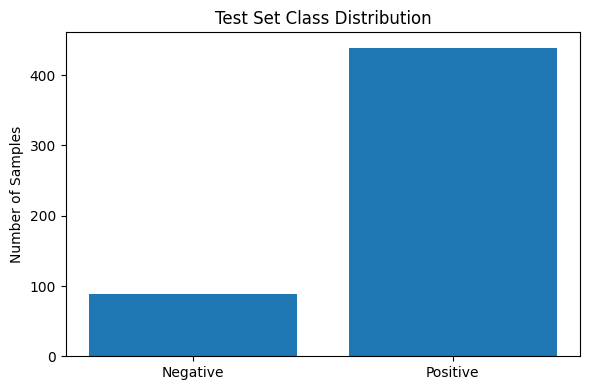


Calculating metrics...

Binary classification metrics:
accuracy: 0.9697
precision: 0.9976
recall: 0.9658
f1: 0.9815
auc: 0.9973

Plotting confusion matrix...


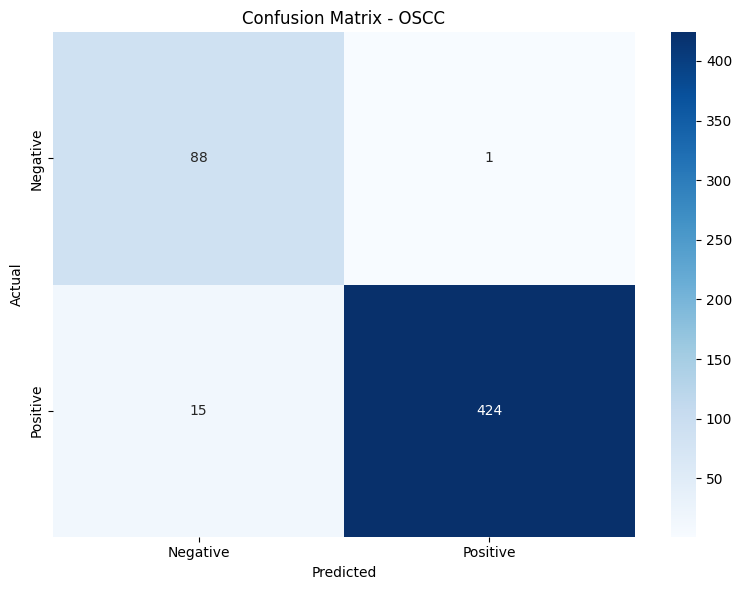

True Positives (TP): 424
False Positives (FP): 1
True Negatives (TN): 88
False Negatives (FN): 15
Sensitivity (Recall): 0.9658
Specificity: 0.9888

Plotting ROC curve...


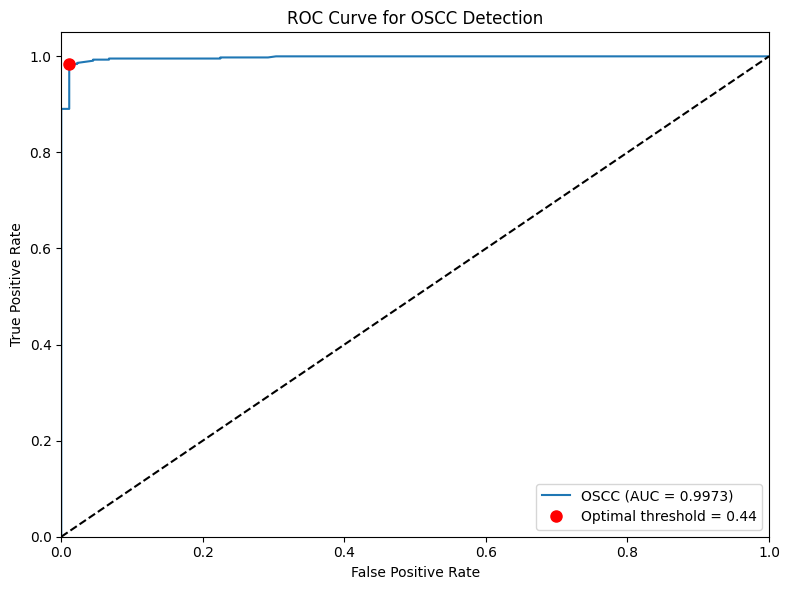


Metrics at optimal threshold (0.4379):
accuracy: 0.9830
precision: 0.9977
recall: 0.9818
f1: 0.9897
auc: 0.9973

Confusion matrix at optimal threshold:


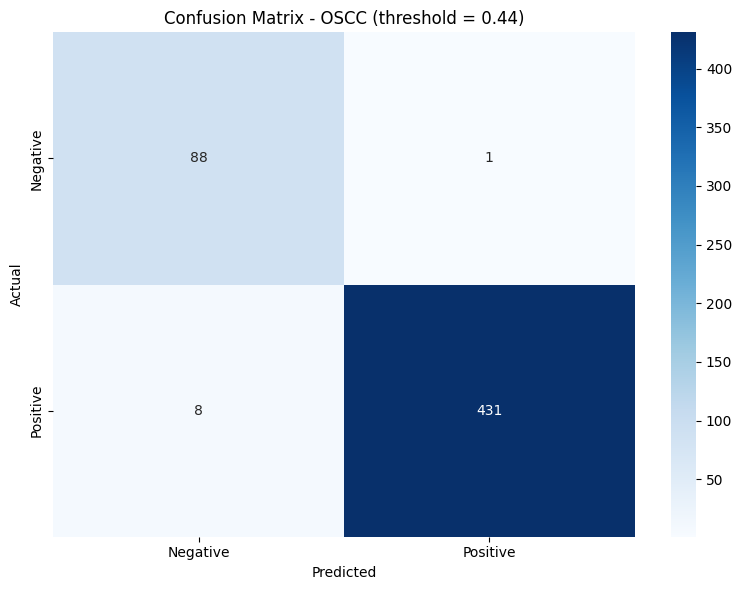

True Positives (TP): 431
False Positives (FP): 1
True Negatives (TN): 88
False Negatives (FN): 8
Sensitivity (Recall): 0.9818
Specificity: 0.9888

Visualizing sample predictions...


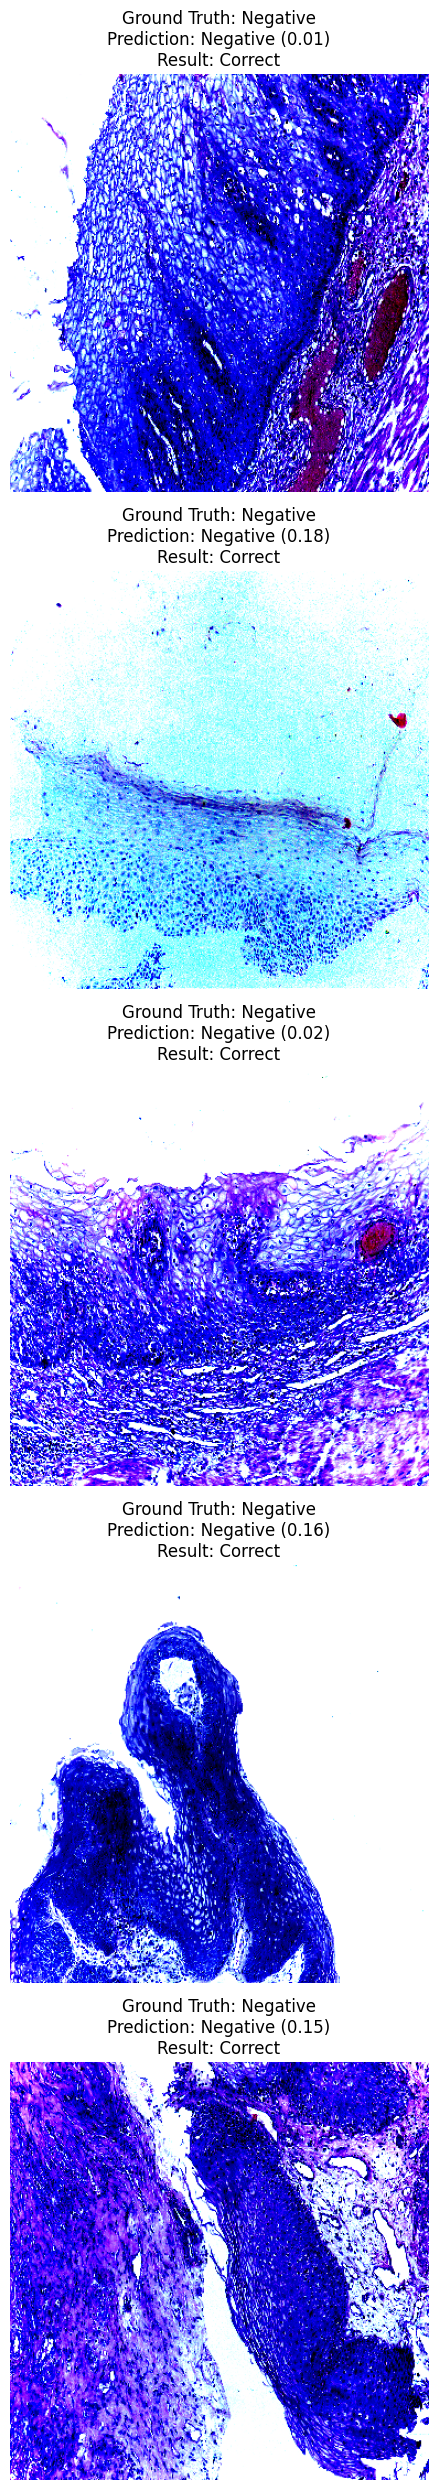


Metrics have been saved to 'oscc_evaluation_metrics.json'


({'accuracy': 0.9696969696969697,
  'precision': 0.9976470588235294,
  'recall': 0.9658314350797267,
  'f1': 0.9814814814814815,
  'auc': 0.9972997875662256,
  'optimal_threshold': 0.4379126727581024,
  'optimal_accuracy': 0.9829545454545454,
  'optimal_precision': 0.9976851851851852,
  'optimal_recall': 0.9817767653758542,
  'optimal_f1': 0.989667049368542,
  'optimal_auc': 0.9972997875662256},
 {'targets': array([[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
     

In [12]:
evaluate()